<center>
<img src="../../img/ods_stickers.jpg" />
</center> 
     
## <center>  [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

#### <center> Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko) 

# <center>Assignment #3. Spring 2019
## <center> Part 3. Gradient boosting

**In this assignment, you're asked to beat a baseline in the ["Flight delays" competition](https://www.kaggle.com/c/flight-delays-fall-2018).**

Prior to working on the assignment, you'd better check out the corresponding course material:
 1. [Classification, Decision Trees and k Nearest Neighbors](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true), the same as an interactive web-based [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn) 
 2. Ensembles:
  - [Bagging](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part1_bagging.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-1-bagging)
  - [Random Forest](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part2_random_forest.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-2-random-forest)
  - [Feature Importance](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part3_feature_importance.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-3-feature-importance)
 3. - [Gradient boosting](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic10_boosting/topic10_gradient_boosting.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-10-gradient-boosting) 
   - Logistic regression, Random Forest, and LightGBM in the "Kaggle Forest Cover Type Prediction" competition: [Kernel](https://www.kaggle.com/kashnitsky/topic-10-practice-with-logit-rf-and-lightgbm) 
 4. You can also practice with demo assignments, which are simpler and already shared with solutions:
  - "Decision trees with a toy task and the UCI Adult dataset": [assignment](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution)
  - "Logistic Regression and Random Forest in the credit scoring problem": [assignment](https://www.kaggle.com/kashnitsky/assignment-5-logit-and-rf-for-credit-scoring) + [solution](https://www.kaggle.com/kashnitsky/a5-demo-logit-and-rf-for-credit-scoring-sol)
 5. There are also 7 video lectures on trees, forests, boosting and their applications: [mlcourse.ai/video](https://mlcourse.ai/video) 

### Your task is to:
 1. beat **"A3 baseline (8 credits)"** on Public LB (**0.73449** LB score)
 2. rename your [team](https://www.kaggle.com/c/flight-delays-fall-2018/team) in full accordance with the course rating
 
 This task is intended to be relatively easy. Here you are not required to upload your reproducible solution.
 
### <center> Deadline for A3: 2019 March 31, 20:59 GMT (London time)

In [124]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, mean_absolute_error
# pip install seaborn 
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import Pool, CatBoostClassifier, cv
import catboost as cb

Download data from the [competition page](https://www.kaggle.com/c/flight-delays-fall-2018/data) and change paths if needed.

In [67]:
train_df = pd.read_csv('flight-delays-fall-2018/flight_delays_train.csv')
test_df = pd.read_csv('flight-delays-fall-2018/flight_delays_test.csv')

In [68]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [69]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
Month                100000 non-null object
DayofMonth           100000 non-null object
DayOfWeek            100000 non-null object
DepTime              100000 non-null int64
UniqueCarrier        100000 non-null object
Origin               100000 non-null object
Dest                 100000 non-null object
Distance             100000 non-null int64
dep_delayed_15min    100000 non-null object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


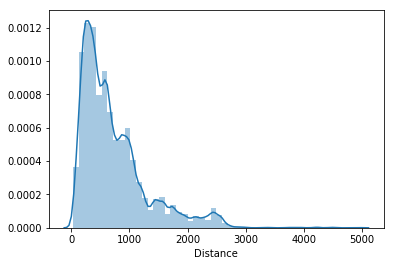

In [71]:
sns.distplot(train_df.Distance)

In [72]:
minutes = [0, 10, 20, 30, 40, 50]

In [73]:
train_df.describe(percentiles=[0.1,0.25,0.5,0.75,0.8,0.9,0.99])

,DepTime,Distance
count,100000.000000,100000.00000
mean,1341.523880,729.39716
std,476.378445,574.61686
min,1.000000,30.00000
10%,713.000000,200.00000
25%,931.000000,317.00000
50%,1330.000000,575.00000
75%,1733.000000,957.00000
80%,1821.000000,1055.00000
90%,2007.000000,1545.00000


In [74]:
print(train_df.Month.unique())
print(train_df.DayofMonth.unique())
print(train_df.DayOfWeek.unique())

['c-8' 'c-4' 'c-9' 'c-11' 'c-10' 'c-1' 'c-7' 'c-6' 'c-5' 'c-3' 'c-12'
 'c-2']
['c-21' 'c-20' 'c-2' 'c-25' 'c-7' 'c-3' 'c-27' 'c-29' 'c-28' 'c-5' 'c-6'
 'c-10' 'c-19' 'c-26' 'c-14' 'c-22' 'c-9' 'c-31' 'c-4' 'c-16' 'c-18'
 'c-30' 'c-1' 'c-24' 'c-15' 'c-17' 'c-8' 'c-12' 'c-13' 'c-11' 'c-23']
['c-7' 'c-3' 'c-5' 'c-6' 'c-4' 'c-2' 'c-1']


In [75]:
train_df['Month'] = train_df.Month.apply(lambda x: x.split('-')[1]).astype('int')
train_df['DayofMonth'] = train_df.DayofMonth.apply(lambda x: x.split('-')[1]).astype('int')
train_df['DayOfWeek'] = train_df.DayOfWeek.apply(lambda x: x.split('-')[1]).astype('int')
train_df['DepTime'] = train_df.DepTime.apply(lambda x: "{:04d}".format(x))
train_df['DepHour'] = train_df.DepTime.apply(lambda x: int(str(x)[:-2]))
train_df['DepMinute'] = train_df.DepTime.apply(lambda x: int(str(x)[2:]))

In [76]:
test_df['Month'] = test_df.Month.apply(lambda x: x.split('-')[1]).astype('int')
test_df['DayofMonth'] = test_df.DayofMonth.apply(lambda x: x.split('-')[1]).astype('int')
test_df['DayOfWeek'] = test_df.DayOfWeek.apply(lambda x: x.split('-')[1]).astype('int')
test_df['DepTime'] = test_df.DepTime.apply(lambda x: "{:04d}".format(x))
test_df['DepHour'] = test_df.DepTime.apply(lambda x: int(str(x)[:-2]))
test_df['DepMinute'] = test_df.DepTime.apply(lambda x: int(str(x)[2:]))

In [77]:
int(str("{:04d}".format(156))[2:])

56

In [78]:
train_df.loc[(train_df.DepMinute == 0), 'dep_delayed_15min'].value_counts(normalize=True)

N    0.840181
Y    0.159819
Name: dep_delayed_15min, dtype: float64

In [79]:
train_df['minutes_0'] = np.where((train_df.DepMinute == 0), 1, 0)
test_df['minutes_0'] = np.where((test_df.DepMinute == 0), 1, 0)
train_df[train_df.DepMinute == 0].head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,DepHour,DepMinute,minutes_0
43,4,18,1,1200,WN,SEA,PHX,1107,N,12,0,1
73,7,2,7,0700,NW,MSP,LAS,1300,N,7,0,1
97,1,1,6,1100,WN,LAS,MDW,1521,N,11,0,1
298,8,15,2,1700,EV,VLD,ATL,208,Y,17,0,1
314,12,29,5,1500,NW,DTW,TPA,983,Y,15,0,1


In [80]:
train_df.DepHour.unique()

array([19, 15, 14, 10, 18,  7,  6, 20, 17, 12, 21, 16,  9, 13, 11, 23,  8,
        5, 22,  0,  4,  2, 24,  1,  3, 25], dtype=int64)

In [81]:
train_df['is_weekday'] = (train_df.DayOfWeek < 6).astype('int')
train_df['is_weekend'] = (train_df.DayOfWeek >= 6).astype('int')
train_df.replace({'DepHour' : { 24 : 0, 25 : 0}}, inplace=True)
train_df['morning'] = ((train_df.DepHour >= 6) & (train_df.DepHour <= 11)).astype('int')
train_df['day'] = ((train_df.DepHour >= 12) & (train_df.DepHour <= 17)).astype('int')
train_df['evening'] = ((train_df.DepHour >= 18) & (train_df.DepHour <= 23)).astype('int')
train_df['night'] = ((train_df.DepHour >= 0) & (train_df.DepHour <= 5)).astype('int')

In [82]:
test_df['is_weekday'] = (test_df.DayOfWeek < 6).astype('int')
test_df['is_weekend'] = (test_df.DayOfWeek >= 6).astype('int')
test_df.replace({'DepHour' : { 24 : 0, 25 : 0}}, inplace=True)
test_df['morning'] = ((test_df.DepHour >= 6) & (test_df.DepHour <= 11)).astype('int')
test_df['day'] = ((test_df.DepHour >= 12) & (test_df.DepHour <= 17)).astype('int')
test_df['evening'] = ((test_df.DepHour >= 18) & (test_df.DepHour <= 23)).astype('int')
test_df['night'] = ((test_df.DepHour >= 0) & (test_df.DepHour <= 5)).astype('int')

In [83]:
train_df['Month'] = train_df.Month.apply(lambda x: str(x))
train_df['DayofMonth'] = train_df.DayofMonth.apply(lambda x: str(x))
train_df['DayOfWeek'] = train_df.DayOfWeek.apply(lambda x: str(x))
train_df['DepHour'] = train_df.DepHour.apply(lambda x: str(x))

In [84]:
test_df['Month'] = test_df.Month.apply(lambda x: str(x))
test_df['DayofMonth'] = test_df.DayofMonth.apply(lambda x: str(x))
test_df['DayOfWeek'] = test_df.DayOfWeek.apply(lambda x: str(x))
test_df['DepHour'] = test_df.DepHour.apply(lambda x: str(x))

In [85]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,DepHour,DepMinute,minutes_0,is_weekday,is_weekend,morning,day,evening,night
0,8,21,7,1934,AA,ATL,DFW,732,N,19,34,0,0,1,0,0,1,0
1,4,20,3,1548,US,PIT,MCO,834,N,15,48,0,1,0,0,1,0,0
2,9,2,5,1422,XE,RDU,CLE,416,N,14,22,0,1,0,0,1,0,0
3,11,25,6,1015,OO,DEN,MEM,872,N,10,15,0,0,1,1,0,0,0
4,10,7,6,1828,WN,MDW,OMA,423,Y,18,28,0,0,1,0,0,1,0


In [86]:
bins=[0,150,1000,2550,6000]
train_df['Distance_bin'] = pd.cut(train_df['Distance'],bins).tolist()
test_df['Distance_bin'] = pd.cut(test_df['Distance'],bins).tolist()

In [87]:
train_df['target'] = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0})

Given flight departure time, carrier's code, departure airport, destination location, and flight distance, you have to predict departure delay for more than 15 minutes. As the simplest benchmark, let's take logistic regression and two features that are easiest to take: DepTime and Distance. This will correspond to **"simple logit baseline"** on Public LB.

In [88]:
train_df_target = train_df[['target']]
train_df = train_df.drop('target', axis=1)

In [89]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,DepHour,DepMinute,minutes_0,is_weekday,is_weekend,morning,day,evening,night,Distance_bin
0,8,21,7,1934,AA,ATL,DFW,732,N,19,34,0,0,1,0,0,1,0,"(150, 1000]"
1,4,20,3,1548,US,PIT,MCO,834,N,15,48,0,1,0,0,1,0,0,"(150, 1000]"
2,9,2,5,1422,XE,RDU,CLE,416,N,14,22,0,1,0,0,1,0,0,"(150, 1000]"
3,11,25,6,1015,OO,DEN,MEM,872,N,10,15,0,0,1,1,0,0,0,"(150, 1000]"
4,10,7,6,1828,WN,MDW,OMA,423,Y,18,28,0,0,1,0,0,1,0,"(150, 1000]"


In [90]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,DepHour,DepMinute,minutes_0,is_weekday,is_weekend,morning,day,evening,night,Distance_bin
0,7,25,3,0615,YV,MRY,PHX,598,6,15,0,1,0,1,0,0,0,"(150, 1000]"
1,4,17,2,0739,WN,LAS,HOU,1235,7,39,0,1,0,1,0,0,0,"(1000, 2550]"
2,12,2,7,0651,MQ,GSP,ORD,577,6,51,0,0,1,1,0,0,0,"(150, 1000]"
3,3,25,7,1614,WN,BWI,MHT,377,16,14,0,0,1,0,1,0,0,"(150, 1000]"
4,6,6,3,1505,UA,ORD,STL,258,15,5,0,1,0,0,1,0,0,"(150, 1000]"


In [107]:
X_train = train_df.drop(['dep_delayed_15min', 'DepMinute', 'is_weekday', 'Distance_bin'], axis=1)
X_test = test_df.drop(['DepMinute',  'is_weekday', 'Distance_bin'], axis=1)

In [108]:
X_train.shape, X_test.shape

((100000, 15), (100000, 15))

In [109]:
X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, train_df_target, 
                     test_size=0.3, random_state=17)

In [110]:
X_train_part.shape, X_valid.shape, y_train_part.shape, y_valid.shape

((70000, 15), (30000, 15), (70000, 1), (30000, 1))

In [111]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
num_vars = ['Distance']
X_train_part[num_vars] = scaler.fit_transform(X_train_part[num_vars])

In [112]:
X_valid[num_vars] = scaler.transform(X_valid[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

In [125]:
params = {'depth': [6, 8, 10],
          'learning_rate' : [0.03, 0.1, 0.15, 0.2],
         'l2_leaf_reg': [4,9],
         'iterations': [250]}
#let us make the catboost model, use_best_model params will make the model prevent overfitting 
cb = CatBoostClassifier(use_best_model=True, random_seed=17, eval_metric="AUC")
cb_model = GridSearchCV(cb, params, scoring="roc_auc", cv = 3)

In [127]:
cb_model.fit(X_train_part, y_train_part, cat_features=cate_features_index)

0:	learn: 0.6767930	total: 64.7ms	remaining: 16.1s
1:	learn: 0.6617207	total: 101ms	remaining: 12.5s
2:	learn: 0.6465686	total: 171ms	remaining: 14.1s
3:	learn: 0.6330876	total: 231ms	remaining: 14.2s
4:	learn: 0.6216428	total: 269ms	remaining: 13.2s
5:	learn: 0.6098449	total: 332ms	remaining: 13.5s
6:	learn: 0.5994756	total: 365ms	remaining: 12.7s
7:	learn: 0.5896309	total: 423ms	remaining: 12.8s
8:	learn: 0.5802904	total: 487ms	remaining: 13s
9:	learn: 0.5721261	total: 524ms	remaining: 12.6s
10:	learn: 0.5637685	total: 574ms	remaining: 12.5s
11:	learn: 0.5571222	total: 602ms	remaining: 11.9s
12:	learn: 0.5498405	total: 658ms	remaining: 12s
13:	learn: 0.5429847	total: 720ms	remaining: 12.1s
14:	learn: 0.5370049	total: 764ms	remaining: 12s
15:	learn: 0.5313533	total: 828ms	remaining: 12.1s
16:	learn: 0.5267149	total: 860ms	remaining: 11.8s
17:	learn: 0.5222534	total: 891ms	remaining: 11.5s
18:	learn: 0.5176964	total: 941ms	remaining: 11.4s
19:	learn: 0.5131781	total: 1.01s	remaining: 1

163:	learn: 0.4214003	total: 10.5s	remaining: 5.5s
164:	learn: 0.4212680	total: 10.6s	remaining: 5.44s
165:	learn: 0.4212437	total: 10.6s	remaining: 5.37s
166:	learn: 0.4211850	total: 10.7s	remaining: 5.3s
167:	learn: 0.4210976	total: 10.8s	remaining: 5.25s
168:	learn: 0.4210240	total: 10.8s	remaining: 5.19s
169:	learn: 0.4209383	total: 10.9s	remaining: 5.13s
170:	learn: 0.4208678	total: 11s	remaining: 5.07s
171:	learn: 0.4207897	total: 11.1s	remaining: 5.01s
172:	learn: 0.4206460	total: 11.1s	remaining: 4.95s
173:	learn: 0.4205858	total: 11.2s	remaining: 4.89s
174:	learn: 0.4204428	total: 11.3s	remaining: 4.83s
175:	learn: 0.4203659	total: 11.3s	remaining: 4.77s
176:	learn: 0.4203236	total: 11.4s	remaining: 4.71s
177:	learn: 0.4201497	total: 11.5s	remaining: 4.65s
178:	learn: 0.4200521	total: 11.6s	remaining: 4.59s
179:	learn: 0.4199784	total: 11.6s	remaining: 4.53s
180:	learn: 0.4198920	total: 11.7s	remaining: 4.46s
181:	learn: 0.4197808	total: 11.8s	remaining: 4.4s
182:	learn: 0.419

74:	learn: 0.4405219	total: 4.52s	remaining: 10.6s
75:	learn: 0.4399419	total: 4.6s	remaining: 10.5s
76:	learn: 0.4395649	total: 4.67s	remaining: 10.5s
77:	learn: 0.4392188	total: 4.74s	remaining: 10.5s
78:	learn: 0.4389796	total: 4.82s	remaining: 10.4s
79:	learn: 0.4384362	total: 4.9s	remaining: 10.4s
80:	learn: 0.4379573	total: 4.96s	remaining: 10.4s
81:	learn: 0.4373132	total: 5.04s	remaining: 10.3s
82:	learn: 0.4369312	total: 5.12s	remaining: 10.3s
83:	learn: 0.4365844	total: 5.18s	remaining: 10.2s
84:	learn: 0.4361532	total: 5.26s	remaining: 10.2s
85:	learn: 0.4358099	total: 5.32s	remaining: 10.1s
86:	learn: 0.4352905	total: 5.4s	remaining: 10.1s
87:	learn: 0.4348085	total: 5.47s	remaining: 10.1s
88:	learn: 0.4345109	total: 5.54s	remaining: 10s
89:	learn: 0.4340431	total: 5.62s	remaining: 10s
90:	learn: 0.4336397	total: 5.7s	remaining: 9.96s
91:	learn: 0.4332803	total: 5.78s	remaining: 9.92s
92:	learn: 0.4329032	total: 5.85s	remaining: 9.88s
93:	learn: 0.4325737	total: 5.91s	remai

235:	learn: 0.4171935	total: 15.1s	remaining: 895ms
236:	learn: 0.4171650	total: 15.2s	remaining: 831ms
237:	learn: 0.4170723	total: 15.2s	remaining: 768ms
238:	learn: 0.4169576	total: 15.3s	remaining: 704ms
239:	learn: 0.4168265	total: 15.4s	remaining: 641ms
240:	learn: 0.4168264	total: 15.4s	remaining: 575ms
241:	learn: 0.4167398	total: 15.5s	remaining: 511ms
242:	learn: 0.4167398	total: 15.5s	remaining: 446ms
243:	learn: 0.4167397	total: 15.5s	remaining: 381ms
244:	learn: 0.4166264	total: 15.6s	remaining: 318ms
245:	learn: 0.4165848	total: 15.6s	remaining: 254ms
246:	learn: 0.4165594	total: 15.7s	remaining: 190ms
247:	learn: 0.4165201	total: 15.8s	remaining: 127ms
248:	learn: 0.4165167	total: 15.8s	remaining: 63.4ms
249:	learn: 0.4165167	total: 15.8s	remaining: 0us
0:	learn: 0.6768707	total: 63.7ms	remaining: 15.9s
1:	learn: 0.6618436	total: 104ms	remaining: 12.9s
2:	learn: 0.6474767	total: 160ms	remaining: 13.2s
3:	learn: 0.6341158	total: 216ms	remaining: 13.3s
4:	learn: 0.6213999	

146:	learn: 0.4254404	total: 9.96s	remaining: 6.98s
147:	learn: 0.4253851	total: 10s	remaining: 6.91s
148:	learn: 0.4252581	total: 10.1s	remaining: 6.85s
149:	learn: 0.4251651	total: 10.2s	remaining: 6.78s
150:	learn: 0.4250058	total: 10.2s	remaining: 6.71s
151:	learn: 0.4248933	total: 10.3s	remaining: 6.65s
152:	learn: 0.4248124	total: 10.4s	remaining: 6.58s
153:	learn: 0.4247515	total: 10.5s	remaining: 6.52s
154:	learn: 0.4246583	total: 10.5s	remaining: 6.46s
155:	learn: 0.4245886	total: 10.6s	remaining: 6.39s
156:	learn: 0.4245317	total: 10.7s	remaining: 6.31s
157:	learn: 0.4243563	total: 10.7s	remaining: 6.25s
158:	learn: 0.4243174	total: 10.8s	remaining: 6.18s
159:	learn: 0.4242166	total: 10.9s	remaining: 6.11s
160:	learn: 0.4240511	total: 10.9s	remaining: 6.05s
161:	learn: 0.4239431	total: 11s	remaining: 5.98s
162:	learn: 0.4238459	total: 11.1s	remaining: 5.92s
163:	learn: 0.4236491	total: 11.2s	remaining: 5.86s
164:	learn: 0.4236320	total: 11.2s	remaining: 5.78s
165:	learn: 0.42

56:	learn: 0.4206359	total: 3.77s	remaining: 12.8s
57:	learn: 0.4203693	total: 3.85s	remaining: 12.7s
58:	learn: 0.4200438	total: 3.92s	remaining: 12.7s
59:	learn: 0.4200086	total: 3.96s	remaining: 12.5s
60:	learn: 0.4195610	total: 4.03s	remaining: 12.5s
61:	learn: 0.4194671	total: 4.08s	remaining: 12.4s
62:	learn: 0.4190290	total: 4.14s	remaining: 12.3s
63:	learn: 0.4189178	total: 4.22s	remaining: 12.3s
64:	learn: 0.4188805	total: 4.27s	remaining: 12.2s
65:	learn: 0.4188224	total: 4.32s	remaining: 12.1s
66:	learn: 0.4186766	total: 4.38s	remaining: 12s
67:	learn: 0.4183723	total: 4.45s	remaining: 11.9s
68:	learn: 0.4180963	total: 4.53s	remaining: 11.9s
69:	learn: 0.4176683	total: 4.61s	remaining: 11.9s
70:	learn: 0.4176321	total: 4.67s	remaining: 11.8s
71:	learn: 0.4175029	total: 4.75s	remaining: 11.7s
72:	learn: 0.4173751	total: 4.81s	remaining: 11.7s
73:	learn: 0.4172213	total: 4.86s	remaining: 11.6s
74:	learn: 0.4171796	total: 4.92s	remaining: 11.5s
75:	learn: 0.4170730	total: 4.98s

216:	learn: 0.4015919	total: 15.2s	remaining: 2.31s
217:	learn: 0.4015133	total: 15.2s	remaining: 2.24s
218:	learn: 0.4014793	total: 15.3s	remaining: 2.17s
219:	learn: 0.4014640	total: 15.4s	remaining: 2.1s
220:	learn: 0.4014274	total: 15.5s	remaining: 2.03s
221:	learn: 0.4013341	total: 15.5s	remaining: 1.96s
222:	learn: 0.4012177	total: 15.6s	remaining: 1.89s
223:	learn: 0.4011443	total: 15.7s	remaining: 1.82s
224:	learn: 0.4010049	total: 15.8s	remaining: 1.76s
225:	learn: 0.4009902	total: 15.9s	remaining: 1.69s
226:	learn: 0.4009189	total: 16s	remaining: 1.62s
227:	learn: 0.4008559	total: 16.1s	remaining: 1.55s
228:	learn: 0.4007668	total: 16.2s	remaining: 1.48s
229:	learn: 0.4007465	total: 16.2s	remaining: 1.41s
230:	learn: 0.4006687	total: 16.3s	remaining: 1.34s
231:	learn: 0.4005842	total: 16.4s	remaining: 1.27s
232:	learn: 0.4005604	total: 16.4s	remaining: 1.2s
233:	learn: 0.4005166	total: 16.5s	remaining: 1.13s
234:	learn: 0.4004734	total: 16.6s	remaining: 1.06s
235:	learn: 0.40

129:	learn: 0.4090883	total: 8.46s	remaining: 7.81s
130:	learn: 0.4089919	total: 8.52s	remaining: 7.74s
131:	learn: 0.4089312	total: 8.59s	remaining: 7.68s
132:	learn: 0.4089310	total: 8.64s	remaining: 7.6s
133:	learn: 0.4089295	total: 8.68s	remaining: 7.51s
134:	learn: 0.4089288	total: 8.72s	remaining: 7.43s
135:	learn: 0.4089020	total: 8.79s	remaining: 7.37s
136:	learn: 0.4088497	total: 8.86s	remaining: 7.31s
137:	learn: 0.4086562	total: 8.93s	remaining: 7.25s
138:	learn: 0.4085748	total: 9s	remaining: 7.19s
139:	learn: 0.4085197	total: 9.08s	remaining: 7.13s
140:	learn: 0.4084744	total: 9.14s	remaining: 7.07s
141:	learn: 0.4084739	total: 9.18s	remaining: 6.99s
142:	learn: 0.4083925	total: 9.26s	remaining: 6.92s
143:	learn: 0.4083200	total: 9.32s	remaining: 6.86s
144:	learn: 0.4080514	total: 9.41s	remaining: 6.81s
145:	learn: 0.4079067	total: 9.48s	remaining: 6.75s
146:	learn: 0.4078236	total: 9.54s	remaining: 6.69s
147:	learn: 0.4078235	total: 9.59s	remaining: 6.61s
148:	learn: 0.40

41:	learn: 0.4273842	total: 2.92s	remaining: 14.5s
42:	learn: 0.4268094	total: 3s	remaining: 14.4s
43:	learn: 0.4264824	total: 3.08s	remaining: 14.4s
44:	learn: 0.4256015	total: 3.16s	remaining: 14.4s
45:	learn: 0.4251674	total: 3.24s	remaining: 14.4s
46:	learn: 0.4244500	total: 3.33s	remaining: 14.4s
47:	learn: 0.4241093	total: 3.4s	remaining: 14.3s
48:	learn: 0.4238153	total: 3.47s	remaining: 14.3s
49:	learn: 0.4232770	total: 3.55s	remaining: 14.2s
50:	learn: 0.4229404	total: 3.62s	remaining: 14.1s
51:	learn: 0.4226773	total: 3.7s	remaining: 14.1s
52:	learn: 0.4226771	total: 3.72s	remaining: 13.8s
53:	learn: 0.4221122	total: 3.8s	remaining: 13.8s
54:	learn: 0.4217333	total: 3.88s	remaining: 13.8s
55:	learn: 0.4217331	total: 3.91s	remaining: 13.5s
56:	learn: 0.4215984	total: 3.95s	remaining: 13.4s
57:	learn: 0.4214356	total: 4s	remaining: 13.2s
58:	learn: 0.4212741	total: 4.05s	remaining: 13.1s
59:	learn: 0.4209698	total: 4.12s	remaining: 13.1s
60:	learn: 0.4208403	total: 4.2s	remaini

202:	learn: 0.4040989	total: 13.8s	remaining: 3.2s
203:	learn: 0.4040770	total: 13.9s	remaining: 3.14s
204:	learn: 0.4040679	total: 14s	remaining: 3.07s
205:	learn: 0.4040414	total: 14.1s	remaining: 3s
206:	learn: 0.4039743	total: 14.1s	remaining: 2.94s
207:	learn: 0.4039502	total: 14.2s	remaining: 2.87s
208:	learn: 0.4038846	total: 14.3s	remaining: 2.8s
209:	learn: 0.4037619	total: 14.3s	remaining: 2.73s
210:	learn: 0.4035820	total: 14.4s	remaining: 2.67s
211:	learn: 0.4035319	total: 14.5s	remaining: 2.6s
212:	learn: 0.4035263	total: 14.6s	remaining: 2.53s
213:	learn: 0.4035167	total: 14.6s	remaining: 2.46s
214:	learn: 0.4035031	total: 14.7s	remaining: 2.4s
215:	learn: 0.4034263	total: 14.8s	remaining: 2.33s
216:	learn: 0.4034174	total: 14.9s	remaining: 2.26s
217:	learn: 0.4034123	total: 14.9s	remaining: 2.19s
218:	learn: 0.4033653	total: 15s	remaining: 2.12s
219:	learn: 0.4033141	total: 15.1s	remaining: 2.06s
220:	learn: 0.4032661	total: 15.1s	remaining: 1.99s
221:	learn: 0.4031967	t

113:	learn: 0.4060945	total: 8.04s	remaining: 9.59s
114:	learn: 0.4059643	total: 8.12s	remaining: 9.53s
115:	learn: 0.4059199	total: 8.2s	remaining: 9.47s
116:	learn: 0.4057695	total: 8.28s	remaining: 9.41s
117:	learn: 0.4056829	total: 8.36s	remaining: 9.35s
118:	learn: 0.4055962	total: 8.44s	remaining: 9.29s
119:	learn: 0.4055889	total: 8.52s	remaining: 9.23s
120:	learn: 0.4054420	total: 8.6s	remaining: 9.16s
121:	learn: 0.4054167	total: 8.67s	remaining: 9.1s
122:	learn: 0.4053348	total: 8.76s	remaining: 9.04s
123:	learn: 0.4052676	total: 8.83s	remaining: 8.97s
124:	learn: 0.4052264	total: 8.91s	remaining: 8.91s
125:	learn: 0.4050224	total: 8.99s	remaining: 8.84s
126:	learn: 0.4049175	total: 9.06s	remaining: 8.77s
127:	learn: 0.4047646	total: 9.14s	remaining: 8.71s
128:	learn: 0.4046660	total: 9.22s	remaining: 8.65s
129:	learn: 0.4044924	total: 9.31s	remaining: 8.6s
130:	learn: 0.4043652	total: 9.39s	remaining: 8.53s
131:	learn: 0.4042795	total: 9.47s	remaining: 8.46s
132:	learn: 0.40

23:	learn: 0.4296116	total: 1.58s	remaining: 14.9s
24:	learn: 0.4289537	total: 1.66s	remaining: 14.9s
25:	learn: 0.4284151	total: 1.74s	remaining: 15s
26:	learn: 0.4277133	total: 1.81s	remaining: 15s
27:	learn: 0.4271711	total: 1.87s	remaining: 14.8s
28:	learn: 0.4260317	total: 1.93s	remaining: 14.7s
29:	learn: 0.4251893	total: 2s	remaining: 14.7s
30:	learn: 0.4250067	total: 2.07s	remaining: 14.6s
31:	learn: 0.4247049	total: 2.13s	remaining: 14.5s
32:	learn: 0.4232859	total: 2.2s	remaining: 14.5s
33:	learn: 0.4229414	total: 2.27s	remaining: 14.4s
34:	learn: 0.4226768	total: 2.33s	remaining: 14.3s
35:	learn: 0.4220077	total: 2.41s	remaining: 14.3s
36:	learn: 0.4219818	total: 2.44s	remaining: 14s
37:	learn: 0.4219437	total: 2.49s	remaining: 13.9s
38:	learn: 0.4215187	total: 2.56s	remaining: 13.8s
39:	learn: 0.4215185	total: 2.59s	remaining: 13.6s
40:	learn: 0.4213192	total: 2.67s	remaining: 13.6s
41:	learn: 0.4211501	total: 2.78s	remaining: 13.7s
42:	learn: 0.4200208	total: 2.9s	remainin

185:	learn: 0.4009143	total: 13.1s	remaining: 4.51s
186:	learn: 0.4009056	total: 13.2s	remaining: 4.44s
187:	learn: 0.4006584	total: 13.3s	remaining: 4.38s
188:	learn: 0.4006436	total: 13.3s	remaining: 4.3s
189:	learn: 0.4006272	total: 13.4s	remaining: 4.24s
190:	learn: 0.4006057	total: 13.5s	remaining: 4.17s
191:	learn: 0.4005132	total: 13.6s	remaining: 4.1s
192:	learn: 0.4004356	total: 13.6s	remaining: 4.03s
193:	learn: 0.4002780	total: 13.7s	remaining: 3.96s
194:	learn: 0.4002251	total: 13.8s	remaining: 3.88s
195:	learn: 0.4001127	total: 13.8s	remaining: 3.82s
196:	learn: 0.4000439	total: 13.9s	remaining: 3.75s
197:	learn: 0.4000336	total: 14s	remaining: 3.68s
198:	learn: 0.4000212	total: 14.1s	remaining: 3.6s
199:	learn: 0.3998844	total: 14.1s	remaining: 3.53s
200:	learn: 0.3998708	total: 14.2s	remaining: 3.46s
201:	learn: 0.3998375	total: 14.3s	remaining: 3.39s
202:	learn: 0.3998164	total: 14.3s	remaining: 3.32s
203:	learn: 0.3997178	total: 14.4s	remaining: 3.25s
204:	learn: 0.399

98:	learn: 0.4091530	total: 6.78s	remaining: 10.3s
99:	learn: 0.4089533	total: 6.85s	remaining: 10.3s
100:	learn: 0.4088312	total: 6.93s	remaining: 10.2s
101:	learn: 0.4086085	total: 7.02s	remaining: 10.2s
102:	learn: 0.4083827	total: 7.1s	remaining: 10.1s
103:	learn: 0.4082212	total: 7.18s	remaining: 10.1s
104:	learn: 0.4080159	total: 7.26s	remaining: 10s
105:	learn: 0.4077934	total: 7.35s	remaining: 9.99s
106:	learn: 0.4075241	total: 7.43s	remaining: 9.94s
107:	learn: 0.4073659	total: 7.51s	remaining: 9.88s
108:	learn: 0.4073426	total: 7.59s	remaining: 9.81s
109:	learn: 0.4069775	total: 7.66s	remaining: 9.76s
110:	learn: 0.4069394	total: 7.74s	remaining: 9.69s
111:	learn: 0.4068034	total: 7.81s	remaining: 9.62s
112:	learn: 0.4067879	total: 7.87s	remaining: 9.54s
113:	learn: 0.4066930	total: 7.94s	remaining: 9.47s
114:	learn: 0.4065213	total: 8.02s	remaining: 9.42s
115:	learn: 0.4064379	total: 8.1s	remaining: 9.36s
116:	learn: 0.4064013	total: 8.18s	remaining: 9.3s
117:	learn: 0.40623

7:	learn: 0.4500822	total: 547ms	remaining: 16.6s
8:	learn: 0.4468416	total: 613ms	remaining: 16.4s
9:	learn: 0.4443735	total: 679ms	remaining: 16.3s
10:	learn: 0.4421999	total: 750ms	remaining: 16.3s
11:	learn: 0.4380171	total: 824ms	remaining: 16.3s
12:	learn: 0.4354222	total: 905ms	remaining: 16.5s
13:	learn: 0.4335932	total: 978ms	remaining: 16.5s
14:	learn: 0.4313486	total: 1.06s	remaining: 16.7s
15:	learn: 0.4300931	total: 1.14s	remaining: 16.7s
16:	learn: 0.4292021	total: 1.22s	remaining: 16.8s
17:	learn: 0.4284041	total: 1.3s	remaining: 16.8s
18:	learn: 0.4279891	total: 1.37s	remaining: 16.6s
19:	learn: 0.4271564	total: 1.43s	remaining: 16.4s
20:	learn: 0.4266029	total: 1.49s	remaining: 16.2s
21:	learn: 0.4256068	total: 1.55s	remaining: 16.1s
22:	learn: 0.4249350	total: 1.63s	remaining: 16.1s
23:	learn: 0.4245051	total: 1.69s	remaining: 15.9s
24:	learn: 0.4243505	total: 1.76s	remaining: 15.9s
25:	learn: 0.4228960	total: 1.84s	remaining: 15.8s
26:	learn: 0.4221133	total: 1.91s	r

168:	learn: 0.3984079	total: 12.5s	remaining: 5.97s
169:	learn: 0.3983027	total: 12.5s	remaining: 5.9s
170:	learn: 0.3982637	total: 12.6s	remaining: 5.83s
171:	learn: 0.3982454	total: 12.7s	remaining: 5.75s
172:	learn: 0.3981797	total: 12.8s	remaining: 5.68s
173:	learn: 0.3981689	total: 12.8s	remaining: 5.61s
174:	learn: 0.3978984	total: 12.9s	remaining: 5.53s
175:	learn: 0.3978097	total: 13s	remaining: 5.46s
176:	learn: 0.3977685	total: 13.1s	remaining: 5.39s
177:	learn: 0.3977405	total: 13.1s	remaining: 5.31s
178:	learn: 0.3977034	total: 13.2s	remaining: 5.24s
179:	learn: 0.3975966	total: 13.3s	remaining: 5.16s
180:	learn: 0.3975800	total: 13.3s	remaining: 5.09s
181:	learn: 0.3975766	total: 13.4s	remaining: 5.01s
182:	learn: 0.3975514	total: 13.5s	remaining: 4.94s
183:	learn: 0.3973547	total: 13.6s	remaining: 4.87s
184:	learn: 0.3973013	total: 13.6s	remaining: 4.79s
185:	learn: 0.3971147	total: 13.7s	remaining: 4.72s
186:	learn: 0.3971055	total: 13.8s	remaining: 4.64s
187:	learn: 0.3

80:	learn: 0.4071625	total: 5.37s	remaining: 11.2s
81:	learn: 0.4071087	total: 5.44s	remaining: 11.1s
82:	learn: 0.4068705	total: 5.53s	remaining: 11.1s
83:	learn: 0.4067804	total: 5.6s	remaining: 11.1s
84:	learn: 0.4065707	total: 5.67s	remaining: 11s
85:	learn: 0.4064049	total: 5.75s	remaining: 11s
86:	learn: 0.4062523	total: 5.83s	remaining: 10.9s
87:	learn: 0.4061372	total: 5.89s	remaining: 10.8s
88:	learn: 0.4059442	total: 5.97s	remaining: 10.8s
89:	learn: 0.4058916	total: 6.04s	remaining: 10.7s
90:	learn: 0.4057385	total: 6.13s	remaining: 10.7s
91:	learn: 0.4054966	total: 6.2s	remaining: 10.7s
92:	learn: 0.4054176	total: 6.27s	remaining: 10.6s
93:	learn: 0.4050360	total: 6.34s	remaining: 10.5s
94:	learn: 0.4050243	total: 6.42s	remaining: 10.5s
95:	learn: 0.4049808	total: 6.49s	remaining: 10.4s
96:	learn: 0.4049080	total: 6.56s	remaining: 10.3s
97:	learn: 0.4048120	total: 6.64s	remaining: 10.3s
98:	learn: 0.4047584	total: 6.72s	remaining: 10.2s
99:	learn: 0.4046722	total: 6.79s	rem

240:	learn: 0.3957389	total: 16.9s	remaining: 631ms
241:	learn: 0.3955155	total: 17s	remaining: 561ms
242:	learn: 0.3954636	total: 17.1s	remaining: 492ms
243:	learn: 0.3952988	total: 17.1s	remaining: 421ms
244:	learn: 0.3952475	total: 17.2s	remaining: 351ms
245:	learn: 0.3952408	total: 17.3s	remaining: 281ms
246:	learn: 0.3952241	total: 17.4s	remaining: 211ms
247:	learn: 0.3952082	total: 17.4s	remaining: 140ms
248:	learn: 0.3952055	total: 17.5s	remaining: 70.2ms
249:	learn: 0.3952026	total: 17.5s	remaining: 0us
0:	learn: 0.5970033	total: 68.5ms	remaining: 17.1s
1:	learn: 0.5407883	total: 107ms	remaining: 13.3s
2:	learn: 0.5057268	total: 170ms	remaining: 14s
3:	learn: 0.4849716	total: 231ms	remaining: 14.2s
4:	learn: 0.4698299	total: 290ms	remaining: 14.2s
5:	learn: 0.4627757	total: 329ms	remaining: 13.4s
6:	learn: 0.4557784	total: 409ms	remaining: 14.2s
7:	learn: 0.4512268	total: 488ms	remaining: 14.8s
8:	learn: 0.4470983	total: 561ms	remaining: 15s
9:	learn: 0.4441975	total: 628ms	rem

151:	learn: 0.4005761	total: 10.6s	remaining: 6.85s
152:	learn: 0.4003976	total: 10.7s	remaining: 6.79s
153:	learn: 0.4003823	total: 10.8s	remaining: 6.71s
154:	learn: 0.4002257	total: 10.8s	remaining: 6.65s
155:	learn: 0.4001508	total: 10.9s	remaining: 6.58s
156:	learn: 0.3999982	total: 11s	remaining: 6.51s
157:	learn: 0.3998987	total: 11.1s	remaining: 6.44s
158:	learn: 0.3998795	total: 11.1s	remaining: 6.37s
159:	learn: 0.3998542	total: 11.2s	remaining: 6.3s
160:	learn: 0.3998275	total: 11.3s	remaining: 6.22s
161:	learn: 0.3996138	total: 11.3s	remaining: 6.15s
162:	learn: 0.3996080	total: 11.4s	remaining: 6.08s
163:	learn: 0.3995913	total: 11.5s	remaining: 6.01s
164:	learn: 0.3993466	total: 11.5s	remaining: 5.95s
165:	learn: 0.3992401	total: 11.6s	remaining: 5.88s
166:	learn: 0.3992297	total: 11.7s	remaining: 5.8s
167:	learn: 0.3991693	total: 11.7s	remaining: 5.73s
168:	learn: 0.3990823	total: 11.8s	remaining: 5.66s
169:	learn: 0.3990098	total: 11.9s	remaining: 5.59s
170:	learn: 0.39

62:	learn: 0.4445528	total: 3.93s	remaining: 11.7s
63:	learn: 0.4437455	total: 4s	remaining: 11.6s
64:	learn: 0.4434132	total: 4.07s	remaining: 11.6s
65:	learn: 0.4430839	total: 4.15s	remaining: 11.6s
66:	learn: 0.4423611	total: 4.22s	remaining: 11.5s
67:	learn: 0.4419742	total: 4.3s	remaining: 11.5s
68:	learn: 0.4413053	total: 4.38s	remaining: 11.5s
69:	learn: 0.4407790	total: 4.42s	remaining: 11.4s
70:	learn: 0.4402010	total: 4.5s	remaining: 11.4s
71:	learn: 0.4396933	total: 4.57s	remaining: 11.3s
72:	learn: 0.4393049	total: 4.64s	remaining: 11.2s
73:	learn: 0.4388160	total: 4.71s	remaining: 11.2s
74:	learn: 0.4382632	total: 4.78s	remaining: 11.2s
75:	learn: 0.4378512	total: 4.85s	remaining: 11.1s
76:	learn: 0.4375918	total: 4.92s	remaining: 11.1s
77:	learn: 0.4373758	total: 4.99s	remaining: 11s
78:	learn: 0.4370482	total: 5.05s	remaining: 10.9s
79:	learn: 0.4366895	total: 5.12s	remaining: 10.9s
80:	learn: 0.4362685	total: 5.19s	remaining: 10.8s
81:	learn: 0.4360357	total: 5.24s	rema

222:	learn: 0.4169553	total: 15s	remaining: 1.81s
223:	learn: 0.4168784	total: 15s	remaining: 1.75s
224:	learn: 0.4168784	total: 15.1s	remaining: 1.67s
225:	learn: 0.4168225	total: 15.1s	remaining: 1.6s
226:	learn: 0.4167350	total: 15.2s	remaining: 1.54s
227:	learn: 0.4167295	total: 15.2s	remaining: 1.47s
228:	learn: 0.4167153	total: 15.3s	remaining: 1.4s
229:	learn: 0.4166865	total: 15.3s	remaining: 1.33s
230:	learn: 0.4166669	total: 15.4s	remaining: 1.27s
231:	learn: 0.4165750	total: 15.5s	remaining: 1.2s
232:	learn: 0.4165327	total: 15.6s	remaining: 1.14s
233:	learn: 0.4164451	total: 15.7s	remaining: 1.07s
234:	learn: 0.4163921	total: 15.7s	remaining: 1s
235:	learn: 0.4163417	total: 15.8s	remaining: 938ms
236:	learn: 0.4163417	total: 15.8s	remaining: 869ms
237:	learn: 0.4163258	total: 15.9s	remaining: 802ms
238:	learn: 0.4162737	total: 16s	remaining: 735ms
239:	learn: 0.4161956	total: 16s	remaining: 668ms
240:	learn: 0.4161956	total: 16.1s	remaining: 600ms
241:	learn: 0.4161402	tota

135:	learn: 0.4238724	total: 9.55s	remaining: 8.01s
136:	learn: 0.4238071	total: 9.63s	remaining: 7.94s
137:	learn: 0.4237104	total: 9.7s	remaining: 7.88s
138:	learn: 0.4235936	total: 9.77s	remaining: 7.8s
139:	learn: 0.4235177	total: 9.82s	remaining: 7.71s
140:	learn: 0.4234355	total: 9.9s	remaining: 7.65s
141:	learn: 0.4232249	total: 9.98s	remaining: 7.59s
142:	learn: 0.4231474	total: 10.1s	remaining: 7.53s
143:	learn: 0.4230096	total: 10.1s	remaining: 7.46s
144:	learn: 0.4228036	total: 10.2s	remaining: 7.38s
145:	learn: 0.4227089	total: 10.3s	remaining: 7.31s
146:	learn: 0.4225968	total: 10.3s	remaining: 7.25s
147:	learn: 0.4223823	total: 10.4s	remaining: 7.19s
148:	learn: 0.4221996	total: 10.5s	remaining: 7.12s
149:	learn: 0.4221375	total: 10.6s	remaining: 7.05s
150:	learn: 0.4219836	total: 10.6s	remaining: 6.98s
151:	learn: 0.4219399	total: 10.7s	remaining: 6.9s
152:	learn: 0.4219136	total: 10.7s	remaining: 6.81s
153:	learn: 0.4218568	total: 10.8s	remaining: 6.74s
154:	learn: 0.42

47:	learn: 0.4568800	total: 2.83s	remaining: 11.9s
48:	learn: 0.4560930	total: 2.88s	remaining: 11.8s
49:	learn: 0.4553584	total: 2.94s	remaining: 11.8s
50:	learn: 0.4544273	total: 3.01s	remaining: 11.7s
51:	learn: 0.4536315	total: 3.08s	remaining: 11.7s
52:	learn: 0.4532635	total: 3.12s	remaining: 11.6s
53:	learn: 0.4526724	total: 3.18s	remaining: 11.5s
54:	learn: 0.4519922	total: 3.25s	remaining: 11.5s
55:	learn: 0.4513980	total: 3.31s	remaining: 11.5s
56:	learn: 0.4508930	total: 3.38s	remaining: 11.5s
57:	learn: 0.4501863	total: 3.46s	remaining: 11.5s
58:	learn: 0.4494450	total: 3.54s	remaining: 11.5s
59:	learn: 0.4488933	total: 3.6s	remaining: 11.4s
60:	learn: 0.4483315	total: 3.68s	remaining: 11.4s
61:	learn: 0.4477683	total: 3.75s	remaining: 11.4s
62:	learn: 0.4473944	total: 3.83s	remaining: 11.4s
63:	learn: 0.4465344	total: 3.9s	remaining: 11.3s
64:	learn: 0.4458931	total: 3.98s	remaining: 11.3s
65:	learn: 0.4454514	total: 4.05s	remaining: 11.3s
66:	learn: 0.4448263	total: 4.11s

211:	learn: 0.4196848	total: 14.3s	remaining: 2.56s
212:	learn: 0.4196689	total: 14.3s	remaining: 2.48s
213:	learn: 0.4196541	total: 14.3s	remaining: 2.41s
214:	learn: 0.4196195	total: 14.4s	remaining: 2.35s
215:	learn: 0.4195035	total: 14.5s	remaining: 2.28s
216:	learn: 0.4194728	total: 14.6s	remaining: 2.22s
217:	learn: 0.4194599	total: 14.6s	remaining: 2.15s
218:	learn: 0.4194595	total: 14.7s	remaining: 2.08s
219:	learn: 0.4193679	total: 14.7s	remaining: 2.01s
220:	learn: 0.4192916	total: 14.8s	remaining: 1.95s
221:	learn: 0.4191789	total: 14.9s	remaining: 1.88s
222:	learn: 0.4191158	total: 15s	remaining: 1.82s
223:	learn: 0.4190874	total: 15.1s	remaining: 1.75s
224:	learn: 0.4189881	total: 15.2s	remaining: 1.69s
225:	learn: 0.4189652	total: 15.3s	remaining: 1.62s
226:	learn: 0.4189151	total: 15.4s	remaining: 1.55s
227:	learn: 0.4188376	total: 15.4s	remaining: 1.49s
228:	learn: 0.4187647	total: 15.5s	remaining: 1.42s
229:	learn: 0.4186645	total: 15.6s	remaining: 1.36s
230:	learn: 0.

124:	learn: 0.4097772	total: 8.38s	remaining: 8.38s
125:	learn: 0.4097262	total: 8.46s	remaining: 8.32s
126:	learn: 0.4096579	total: 8.53s	remaining: 8.26s
127:	learn: 0.4095552	total: 8.62s	remaining: 8.22s
128:	learn: 0.4092370	total: 8.71s	remaining: 8.18s
129:	learn: 0.4090618	total: 8.79s	remaining: 8.12s
130:	learn: 0.4088255	total: 8.87s	remaining: 8.06s
131:	learn: 0.4086572	total: 8.95s	remaining: 8s
132:	learn: 0.4086104	total: 9.02s	remaining: 7.93s
133:	learn: 0.4085064	total: 9.1s	remaining: 7.88s
134:	learn: 0.4083844	total: 9.16s	remaining: 7.81s
135:	learn: 0.4081736	total: 9.24s	remaining: 7.75s
136:	learn: 0.4081454	total: 9.3s	remaining: 7.67s
137:	learn: 0.4079912	total: 9.38s	remaining: 7.61s
138:	learn: 0.4078572	total: 9.45s	remaining: 7.55s
139:	learn: 0.4077113	total: 9.53s	remaining: 7.49s
140:	learn: 0.4076672	total: 9.61s	remaining: 7.43s
141:	learn: 0.4075947	total: 9.68s	remaining: 7.36s
142:	learn: 0.4075164	total: 9.75s	remaining: 7.3s
143:	learn: 0.4073

34:	learn: 0.4292355	total: 2.45s	remaining: 15s
35:	learn: 0.4289132	total: 2.52s	remaining: 15s
36:	learn: 0.4285975	total: 2.6s	remaining: 15s
37:	learn: 0.4275805	total: 2.67s	remaining: 14.9s
38:	learn: 0.4267628	total: 2.75s	remaining: 14.9s
39:	learn: 0.4261243	total: 2.83s	remaining: 14.8s
40:	learn: 0.4258504	total: 2.9s	remaining: 14.8s
41:	learn: 0.4257143	total: 2.96s	remaining: 14.7s
42:	learn: 0.4249835	total: 3.04s	remaining: 14.7s
43:	learn: 0.4246622	total: 3.12s	remaining: 14.6s
44:	learn: 0.4242751	total: 3.2s	remaining: 14.6s
45:	learn: 0.4240768	total: 3.25s	remaining: 14.4s
46:	learn: 0.4234995	total: 3.33s	remaining: 14.4s
47:	learn: 0.4232728	total: 3.41s	remaining: 14.3s
48:	learn: 0.4228114	total: 3.48s	remaining: 14.3s
49:	learn: 0.4221176	total: 3.56s	remaining: 14.2s
50:	learn: 0.4219788	total: 3.62s	remaining: 14.1s
51:	learn: 0.4216333	total: 3.69s	remaining: 14.1s
52:	learn: 0.4210740	total: 3.77s	remaining: 14s
53:	learn: 0.4210264	total: 3.81s	remainin

194:	learn: 0.4044941	total: 13.1s	remaining: 3.7s
195:	learn: 0.4044478	total: 13.2s	remaining: 3.63s
196:	learn: 0.4044384	total: 13.2s	remaining: 3.56s
197:	learn: 0.4043840	total: 13.3s	remaining: 3.5s
198:	learn: 0.4043301	total: 13.4s	remaining: 3.44s
199:	learn: 0.4042611	total: 13.5s	remaining: 3.38s
200:	learn: 0.4042591	total: 13.6s	remaining: 3.32s
201:	learn: 0.4042550	total: 13.7s	remaining: 3.26s
202:	learn: 0.4041569	total: 13.8s	remaining: 3.19s
203:	learn: 0.4041072	total: 13.9s	remaining: 3.13s
204:	learn: 0.4040146	total: 14s	remaining: 3.07s
205:	learn: 0.4039229	total: 14.1s	remaining: 3s
206:	learn: 0.4039176	total: 14.1s	remaining: 2.93s
207:	learn: 0.4038955	total: 14.2s	remaining: 2.87s
208:	learn: 0.4038490	total: 14.3s	remaining: 2.8s
209:	learn: 0.4038048	total: 14.3s	remaining: 2.73s
210:	learn: 0.4037747	total: 14.4s	remaining: 2.67s
211:	learn: 0.4036707	total: 14.5s	remaining: 2.6s
212:	learn: 0.4036462	total: 14.6s	remaining: 2.53s
213:	learn: 0.4035851

106:	learn: 0.4140250	total: 6.89s	remaining: 9.21s
107:	learn: 0.4138808	total: 6.97s	remaining: 9.17s
108:	learn: 0.4137189	total: 7.05s	remaining: 9.12s
109:	learn: 0.4135453	total: 7.13s	remaining: 9.07s
110:	learn: 0.4135354	total: 7.17s	remaining: 8.98s
111:	learn: 0.4131820	total: 7.25s	remaining: 8.93s
112:	learn: 0.4130285	total: 7.33s	remaining: 8.88s
113:	learn: 0.4129398	total: 7.41s	remaining: 8.84s
114:	learn: 0.4128848	total: 7.48s	remaining: 8.78s
115:	learn: 0.4128831	total: 7.53s	remaining: 8.7s
116:	learn: 0.4124890	total: 7.62s	remaining: 8.66s
117:	learn: 0.4122207	total: 7.69s	remaining: 8.61s
118:	learn: 0.4121321	total: 7.79s	remaining: 8.57s
119:	learn: 0.4120314	total: 7.89s	remaining: 8.55s
120:	learn: 0.4119251	total: 7.98s	remaining: 8.51s
121:	learn: 0.4119127	total: 8.05s	remaining: 8.45s
122:	learn: 0.4118956	total: 8.13s	remaining: 8.39s
123:	learn: 0.4118328	total: 8.2s	remaining: 8.33s
124:	learn: 0.4115547	total: 8.27s	remaining: 8.27s
125:	learn: 0.

15:	learn: 0.4377041	total: 1.04s	remaining: 15.3s
16:	learn: 0.4354868	total: 1.12s	remaining: 15.3s
17:	learn: 0.4335725	total: 1.19s	remaining: 15.4s
18:	learn: 0.4323268	total: 1.27s	remaining: 15.4s
19:	learn: 0.4315837	total: 1.35s	remaining: 15.6s
20:	learn: 0.4306562	total: 1.43s	remaining: 15.5s
21:	learn: 0.4296027	total: 1.5s	remaining: 15.6s
22:	learn: 0.4287257	total: 1.57s	remaining: 15.5s
23:	learn: 0.4277006	total: 1.65s	remaining: 15.5s
24:	learn: 0.4271458	total: 1.71s	remaining: 15.4s
25:	learn: 0.4265434	total: 1.78s	remaining: 15.4s
26:	learn: 0.4259531	total: 1.84s	remaining: 15.2s
27:	learn: 0.4257333	total: 1.9s	remaining: 15s
28:	learn: 0.4251804	total: 1.97s	remaining: 15s
29:	learn: 0.4245234	total: 2.05s	remaining: 15.1s
30:	learn: 0.4240065	total: 2.15s	remaining: 15.2s
31:	learn: 0.4239386	total: 2.19s	remaining: 14.9s
32:	learn: 0.4237668	total: 2.25s	remaining: 14.8s
33:	learn: 0.4231058	total: 2.33s	remaining: 14.8s
34:	learn: 0.4224567	total: 2.42s	rem

177:	learn: 0.3997375	total: 12.9s	remaining: 5.2s
178:	learn: 0.3996856	total: 12.9s	remaining: 5.13s
179:	learn: 0.3995682	total: 13s	remaining: 5.05s
180:	learn: 0.3994794	total: 13.1s	remaining: 4.98s
181:	learn: 0.3994530	total: 13.1s	remaining: 4.91s
182:	learn: 0.3994270	total: 13.2s	remaining: 4.84s
183:	learn: 0.3993995	total: 13.3s	remaining: 4.76s
184:	learn: 0.3992826	total: 13.4s	remaining: 4.7s
185:	learn: 0.3991033	total: 13.4s	remaining: 4.62s
186:	learn: 0.3990130	total: 13.5s	remaining: 4.55s
187:	learn: 0.3989230	total: 13.6s	remaining: 4.48s
188:	learn: 0.3988985	total: 13.6s	remaining: 4.4s
189:	learn: 0.3988918	total: 13.7s	remaining: 4.33s
190:	learn: 0.3987838	total: 13.8s	remaining: 4.26s
191:	learn: 0.3987676	total: 13.9s	remaining: 4.19s
192:	learn: 0.3986033	total: 14s	remaining: 4.12s
193:	learn: 0.3985295	total: 14s	remaining: 4.05s
194:	learn: 0.3985157	total: 14.1s	remaining: 3.98s
195:	learn: 0.3984110	total: 14.2s	remaining: 3.92s
196:	learn: 0.3982845

90:	learn: 0.4094834	total: 5.97s	remaining: 10.4s
91:	learn: 0.4092971	total: 6.03s	remaining: 10.4s
92:	learn: 0.4092531	total: 6.11s	remaining: 10.3s
93:	learn: 0.4090718	total: 6.21s	remaining: 10.3s
94:	learn: 0.4089922	total: 6.3s	remaining: 10.3s
95:	learn: 0.4088224	total: 6.37s	remaining: 10.2s
96:	learn: 0.4088042	total: 6.43s	remaining: 10.1s
97:	learn: 0.4086548	total: 6.5s	remaining: 10.1s
98:	learn: 0.4083880	total: 6.57s	remaining: 10s
99:	learn: 0.4082182	total: 6.65s	remaining: 9.97s
100:	learn: 0.4080669	total: 6.73s	remaining: 9.93s
101:	learn: 0.4079614	total: 6.81s	remaining: 9.88s
102:	learn: 0.4077513	total: 6.88s	remaining: 9.83s
103:	learn: 0.4076618	total: 6.95s	remaining: 9.76s
104:	learn: 0.4076526	total: 7.02s	remaining: 9.69s
105:	learn: 0.4075553	total: 7.08s	remaining: 9.62s
106:	learn: 0.4074444	total: 7.15s	remaining: 9.55s
107:	learn: 0.4074111	total: 7.22s	remaining: 9.5s
108:	learn: 0.4072749	total: 7.3s	remaining: 9.44s
109:	learn: 0.4071063	total:

0:	learn: 0.6183683	total: 64.3ms	remaining: 16s
1:	learn: 0.5678490	total: 104ms	remaining: 12.9s
2:	learn: 0.5305860	total: 161ms	remaining: 13.3s
3:	learn: 0.5053969	total: 220ms	remaining: 13.5s
4:	learn: 0.4909300	total: 250ms	remaining: 12.3s
5:	learn: 0.4786390	total: 313ms	remaining: 12.7s
6:	learn: 0.4694766	total: 395ms	remaining: 13.7s
7:	learn: 0.4621950	total: 455ms	remaining: 13.7s
8:	learn: 0.4567431	total: 522ms	remaining: 14s
9:	learn: 0.4526631	total: 605ms	remaining: 14.5s
10:	learn: 0.4503150	total: 671ms	remaining: 14.6s
11:	learn: 0.4464787	total: 742ms	remaining: 14.7s
12:	learn: 0.4444769	total: 799ms	remaining: 14.6s
13:	learn: 0.4420948	total: 884ms	remaining: 14.9s
14:	learn: 0.4391350	total: 975ms	remaining: 15.3s
15:	learn: 0.4366124	total: 1.05s	remaining: 15.4s
16:	learn: 0.4357359	total: 1.12s	remaining: 15.3s
17:	learn: 0.4344830	total: 1.19s	remaining: 15.3s
18:	learn: 0.4330862	total: 1.26s	remaining: 15.4s
19:	learn: 0.4322511	total: 1.32s	remaining:

163:	learn: 0.4011603	total: 12.7s	remaining: 6.68s
164:	learn: 0.4011470	total: 12.8s	remaining: 6.61s
165:	learn: 0.4010928	total: 12.9s	remaining: 6.53s
166:	learn: 0.4010043	total: 13s	remaining: 6.46s
167:	learn: 0.4009295	total: 13.1s	remaining: 6.38s
168:	learn: 0.4009155	total: 13.1s	remaining: 6.3s
169:	learn: 0.4008378	total: 13.2s	remaining: 6.23s
170:	learn: 0.4006870	total: 13.3s	remaining: 6.15s
171:	learn: 0.4006529	total: 13.4s	remaining: 6.08s
172:	learn: 0.4005255	total: 13.5s	remaining: 6s
173:	learn: 0.4003883	total: 13.6s	remaining: 5.92s
174:	learn: 0.4003239	total: 13.6s	remaining: 5.84s
175:	learn: 0.4002322	total: 13.7s	remaining: 5.77s
176:	learn: 0.4001483	total: 13.8s	remaining: 5.69s
177:	learn: 0.4001072	total: 13.9s	remaining: 5.62s
178:	learn: 0.4000205	total: 14s	remaining: 5.54s
179:	learn: 0.3999636	total: 14s	remaining: 5.46s
180:	learn: 0.3999537	total: 14.1s	remaining: 5.38s
181:	learn: 0.3998612	total: 14.2s	remaining: 5.31s
182:	learn: 0.3997908	

74:	learn: 0.4071943	total: 4.91s	remaining: 11.4s
75:	learn: 0.4070944	total: 4.98s	remaining: 11.4s
76:	learn: 0.4070813	total: 5.04s	remaining: 11.3s
77:	learn: 0.4068603	total: 5.11s	remaining: 11.3s
78:	learn: 0.4067736	total: 5.18s	remaining: 11.2s
79:	learn: 0.4065386	total: 5.26s	remaining: 11.2s
80:	learn: 0.4062484	total: 5.34s	remaining: 11.2s
81:	learn: 0.4060549	total: 5.42s	remaining: 11.1s
82:	learn: 0.4059614	total: 5.48s	remaining: 11s
83:	learn: 0.4057529	total: 5.56s	remaining: 11s
84:	learn: 0.4056800	total: 5.64s	remaining: 10.9s
85:	learn: 0.4055236	total: 5.71s	remaining: 10.9s
86:	learn: 0.4054884	total: 5.78s	remaining: 10.8s
87:	learn: 0.4053316	total: 5.85s	remaining: 10.8s
88:	learn: 0.4051974	total: 5.93s	remaining: 10.7s
89:	learn: 0.4051667	total: 5.99s	remaining: 10.7s
90:	learn: 0.4051596	total: 6.05s	remaining: 10.6s
91:	learn: 0.4050634	total: 6.12s	remaining: 10.5s
92:	learn: 0.4049463	total: 6.19s	remaining: 10.4s
93:	learn: 0.4047823	total: 6.27s	r

235:	learn: 0.3930243	total: 17s	remaining: 1.01s
236:	learn: 0.3929533	total: 17.1s	remaining: 937ms
237:	learn: 0.3929483	total: 17.2s	remaining: 866ms
238:	learn: 0.3929384	total: 17.3s	remaining: 794ms
239:	learn: 0.3929358	total: 17.3s	remaining: 723ms
240:	learn: 0.3928945	total: 17.4s	remaining: 651ms
241:	learn: 0.3928838	total: 17.5s	remaining: 579ms
242:	learn: 0.3928391	total: 17.6s	remaining: 507ms
243:	learn: 0.3927632	total: 17.7s	remaining: 434ms
244:	learn: 0.3927114	total: 17.7s	remaining: 362ms
245:	learn: 0.3926512	total: 17.8s	remaining: 290ms
246:	learn: 0.3926347	total: 17.9s	remaining: 217ms
247:	learn: 0.3925989	total: 17.9s	remaining: 145ms
248:	learn: 0.3924826	total: 18s	remaining: 72.4ms
249:	learn: 0.3924732	total: 18.1s	remaining: 0us
0:	learn: 0.5971524	total: 66.4ms	remaining: 16.5s
1:	learn: 0.5409975	total: 106ms	remaining: 13.2s
2:	learn: 0.5137383	total: 129ms	remaining: 10.6s
3:	learn: 0.4899424	total: 163ms	remaining: 10s
4:	learn: 0.4753035	total:

148:	learn: 0.4001101	total: 10.3s	remaining: 6.95s
149:	learn: 0.3999823	total: 10.3s	remaining: 6.89s
150:	learn: 0.3999617	total: 10.4s	remaining: 6.83s
151:	learn: 0.3999503	total: 10.5s	remaining: 6.77s
152:	learn: 0.3998682	total: 10.6s	remaining: 6.7s
153:	learn: 0.3996452	total: 10.6s	remaining: 6.63s
154:	learn: 0.3995597	total: 10.7s	remaining: 6.56s
155:	learn: 0.3994946	total: 10.8s	remaining: 6.49s
156:	learn: 0.3994804	total: 10.8s	remaining: 6.42s
157:	learn: 0.3994769	total: 10.9s	remaining: 6.35s
158:	learn: 0.3993852	total: 11s	remaining: 6.28s
159:	learn: 0.3993433	total: 11s	remaining: 6.21s
160:	learn: 0.3993382	total: 11.1s	remaining: 6.14s
161:	learn: 0.3993342	total: 11.2s	remaining: 6.08s
162:	learn: 0.3992995	total: 11.3s	remaining: 6.01s
163:	learn: 0.3992056	total: 11.3s	remaining: 5.95s
164:	learn: 0.3992021	total: 11.4s	remaining: 5.88s
165:	learn: 0.3991159	total: 11.5s	remaining: 5.81s
166:	learn: 0.3988744	total: 11.6s	remaining: 5.75s
167:	learn: 0.398

58:	learn: 0.4150162	total: 3.83s	remaining: 12.4s
59:	learn: 0.4148423	total: 3.91s	remaining: 12.4s
60:	learn: 0.4145018	total: 3.98s	remaining: 12.3s
61:	learn: 0.4142679	total: 4.06s	remaining: 12.3s
62:	learn: 0.4140506	total: 4.13s	remaining: 12.3s
63:	learn: 0.4138367	total: 4.21s	remaining: 12.2s
64:	learn: 0.4135203	total: 4.28s	remaining: 12.2s
65:	learn: 0.4130747	total: 4.36s	remaining: 12.2s
66:	learn: 0.4129947	total: 4.43s	remaining: 12.1s
67:	learn: 0.4120537	total: 4.51s	remaining: 12.1s
68:	learn: 0.4118831	total: 4.58s	remaining: 12s
69:	learn: 0.4117137	total: 4.66s	remaining: 12s
70:	learn: 0.4116417	total: 4.73s	remaining: 11.9s
71:	learn: 0.4112078	total: 4.81s	remaining: 11.9s
72:	learn: 0.4109781	total: 4.88s	remaining: 11.8s
73:	learn: 0.4108484	total: 4.96s	remaining: 11.8s
74:	learn: 0.4107068	total: 5.04s	remaining: 11.8s
75:	learn: 0.4105726	total: 5.12s	remaining: 11.7s
76:	learn: 0.4103196	total: 5.2s	remaining: 11.7s
77:	learn: 0.4102136	total: 5.27s	re

220:	learn: 0.3963754	total: 15.8s	remaining: 2.07s
221:	learn: 0.3963451	total: 15.9s	remaining: 2s
222:	learn: 0.3962287	total: 15.9s	remaining: 1.93s
223:	learn: 0.3961877	total: 16s	remaining: 1.86s
224:	learn: 0.3960454	total: 16.1s	remaining: 1.79s
225:	learn: 0.3959399	total: 16.2s	remaining: 1.72s
226:	learn: 0.3959379	total: 16.2s	remaining: 1.64s
227:	learn: 0.3958511	total: 16.3s	remaining: 1.57s
228:	learn: 0.3958297	total: 16.4s	remaining: 1.5s
229:	learn: 0.3957215	total: 16.4s	remaining: 1.43s
230:	learn: 0.3956881	total: 16.5s	remaining: 1.36s
231:	learn: 0.3955685	total: 16.6s	remaining: 1.29s
232:	learn: 0.3954607	total: 16.7s	remaining: 1.22s
233:	learn: 0.3953996	total: 16.7s	remaining: 1.14s
234:	learn: 0.3953841	total: 16.8s	remaining: 1.07s
235:	learn: 0.3953677	total: 16.9s	remaining: 1s
236:	learn: 0.3953453	total: 17s	remaining: 930ms
237:	learn: 0.3952981	total: 17s	remaining: 858ms
238:	learn: 0.3952944	total: 17.1s	remaining: 787ms
239:	learn: 0.3952907	tot

133:	learn: 0.4225570	total: 11.8s	remaining: 10.2s
134:	learn: 0.4224456	total: 11.9s	remaining: 10.1s
135:	learn: 0.4222853	total: 12s	remaining: 10.1s
136:	learn: 0.4220946	total: 12.2s	remaining: 10s
137:	learn: 0.4220131	total: 12.3s	remaining: 9.95s
138:	learn: 0.4219458	total: 12.3s	remaining: 9.86s
139:	learn: 0.4217843	total: 12.5s	remaining: 9.8s
140:	learn: 0.4216933	total: 12.6s	remaining: 9.72s
141:	learn: 0.4216621	total: 12.6s	remaining: 9.6s
142:	learn: 0.4215341	total: 12.7s	remaining: 9.51s
143:	learn: 0.4213348	total: 12.8s	remaining: 9.42s
144:	learn: 0.4211305	total: 12.9s	remaining: 9.35s
145:	learn: 0.4210927	total: 13s	remaining: 9.24s
146:	learn: 0.4208736	total: 13.1s	remaining: 9.18s
147:	learn: 0.4207826	total: 13.2s	remaining: 9.11s
148:	learn: 0.4207757	total: 13.3s	remaining: 8.99s
149:	learn: 0.4206321	total: 13.4s	remaining: 8.91s
150:	learn: 0.4205138	total: 13.5s	remaining: 8.85s
151:	learn: 0.4204707	total: 13.6s	remaining: 8.74s
152:	learn: 0.420398

44:	learn: 0.4567885	total: 3.59s	remaining: 16.3s
45:	learn: 0.4556275	total: 3.69s	remaining: 16.4s
46:	learn: 0.4546731	total: 3.79s	remaining: 16.4s
47:	learn: 0.4538352	total: 3.85s	remaining: 16.2s
48:	learn: 0.4531732	total: 3.91s	remaining: 16s
49:	learn: 0.4523824	total: 3.99s	remaining: 16s
50:	learn: 0.4516747	total: 4.04s	remaining: 15.8s
51:	learn: 0.4508333	total: 4.14s	remaining: 15.8s
52:	learn: 0.4502354	total: 4.2s	remaining: 15.6s
53:	learn: 0.4494064	total: 4.29s	remaining: 15.6s
54:	learn: 0.4488116	total: 4.35s	remaining: 15.4s
55:	learn: 0.4482352	total: 4.45s	remaining: 15.4s
56:	learn: 0.4476354	total: 4.55s	remaining: 15.4s
57:	learn: 0.4465807	total: 4.64s	remaining: 15.4s
58:	learn: 0.4457834	total: 4.73s	remaining: 15.3s
59:	learn: 0.4452394	total: 4.84s	remaining: 15.3s
60:	learn: 0.4444851	total: 4.89s	remaining: 15.2s
61:	learn: 0.4437354	total: 5s	remaining: 15.2s
62:	learn: 0.4430966	total: 5.05s	remaining: 15s
63:	learn: 0.4422098	total: 5.17s	remaini

204:	learn: 0.4160842	total: 16.6s	remaining: 3.65s
205:	learn: 0.4160568	total: 16.7s	remaining: 3.56s
206:	learn: 0.4160555	total: 16.7s	remaining: 3.47s
207:	learn: 0.4159577	total: 16.8s	remaining: 3.4s
208:	learn: 0.4158980	total: 16.9s	remaining: 3.32s
209:	learn: 0.4156820	total: 17.1s	remaining: 3.25s
210:	learn: 0.4156156	total: 17.2s	remaining: 3.17s
211:	learn: 0.4156156	total: 17.2s	remaining: 3.08s
212:	learn: 0.4155042	total: 17.3s	remaining: 3s
213:	learn: 0.4154079	total: 17.4s	remaining: 2.93s
214:	learn: 0.4152733	total: 17.5s	remaining: 2.85s
215:	learn: 0.4152612	total: 17.5s	remaining: 2.76s
216:	learn: 0.4152519	total: 17.6s	remaining: 2.67s
217:	learn: 0.4152505	total: 17.6s	remaining: 2.59s
218:	learn: 0.4150707	total: 17.7s	remaining: 2.51s
219:	learn: 0.4150284	total: 17.8s	remaining: 2.43s
220:	learn: 0.4150099	total: 17.9s	remaining: 2.35s
221:	learn: 0.4149338	total: 18s	remaining: 2.27s
222:	learn: 0.4149337	total: 18s	remaining: 2.18s
223:	learn: 0.414815

117:	learn: 0.4272187	total: 10.3s	remaining: 11.5s
118:	learn: 0.4269723	total: 10.4s	remaining: 11.4s
119:	learn: 0.4268852	total: 10.5s	remaining: 11.3s
120:	learn: 0.4266031	total: 10.6s	remaining: 11.3s
121:	learn: 0.4263188	total: 10.7s	remaining: 11.2s
122:	learn: 0.4262471	total: 10.8s	remaining: 11.1s
123:	learn: 0.4260814	total: 10.9s	remaining: 11.1s
124:	learn: 0.4257655	total: 11s	remaining: 11s
125:	learn: 0.4256316	total: 11.1s	remaining: 10.9s
126:	learn: 0.4254422	total: 11.2s	remaining: 10.8s
127:	learn: 0.4253509	total: 11.2s	remaining: 10.7s
128:	learn: 0.4252411	total: 11.3s	remaining: 10.6s
129:	learn: 0.4251511	total: 11.3s	remaining: 10.4s
130:	learn: 0.4248648	total: 11.4s	remaining: 10.4s
131:	learn: 0.4247993	total: 11.5s	remaining: 10.3s
132:	learn: 0.4246309	total: 11.6s	remaining: 10.2s
133:	learn: 0.4245899	total: 11.6s	remaining: 10.1s
134:	learn: 0.4242086	total: 11.7s	remaining: 9.99s
135:	learn: 0.4240464	total: 11.8s	remaining: 9.92s
136:	learn: 0.42

28:	learn: 0.4309461	total: 2.19s	remaining: 16.7s
29:	learn: 0.4301357	total: 2.31s	remaining: 16.9s
30:	learn: 0.4293083	total: 2.4s	remaining: 17s
31:	learn: 0.4282883	total: 2.51s	remaining: 17.1s
32:	learn: 0.4273841	total: 2.62s	remaining: 17.2s
33:	learn: 0.4266962	total: 2.73s	remaining: 17.4s
34:	learn: 0.4262872	total: 2.81s	remaining: 17.2s
35:	learn: 0.4258506	total: 2.88s	remaining: 17.1s
36:	learn: 0.4253891	total: 2.99s	remaining: 17.2s
37:	learn: 0.4247516	total: 3.09s	remaining: 17.3s
38:	learn: 0.4242785	total: 3.2s	remaining: 17.3s
39:	learn: 0.4239825	total: 3.26s	remaining: 17.1s
40:	learn: 0.4236085	total: 3.34s	remaining: 17s
41:	learn: 0.4232017	total: 3.45s	remaining: 17.1s
42:	learn: 0.4226951	total: 3.56s	remaining: 17.2s
43:	learn: 0.4220653	total: 3.65s	remaining: 17.1s
44:	learn: 0.4215563	total: 3.74s	remaining: 17s
45:	learn: 0.4212036	total: 3.84s	remaining: 17s
46:	learn: 0.4209224	total: 3.93s	remaining: 17s
47:	learn: 0.4208509	total: 3.97s	remaining

188:	learn: 0.3991852	total: 17.2s	remaining: 5.56s
189:	learn: 0.3991643	total: 17.3s	remaining: 5.47s
190:	learn: 0.3991021	total: 17.4s	remaining: 5.38s
191:	learn: 0.3990455	total: 17.5s	remaining: 5.3s
192:	learn: 0.3989634	total: 17.7s	remaining: 5.21s
193:	learn: 0.3986970	total: 17.8s	remaining: 5.13s
194:	learn: 0.3985991	total: 17.9s	remaining: 5.05s
195:	learn: 0.3985754	total: 18s	remaining: 4.96s
196:	learn: 0.3985391	total: 18.1s	remaining: 4.87s
197:	learn: 0.3985057	total: 18.2s	remaining: 4.78s
198:	learn: 0.3984632	total: 18.3s	remaining: 4.7s
199:	learn: 0.3983816	total: 18.4s	remaining: 4.61s
200:	learn: 0.3982833	total: 18.5s	remaining: 4.52s
201:	learn: 0.3982696	total: 18.6s	remaining: 4.43s
202:	learn: 0.3982418	total: 18.7s	remaining: 4.34s
203:	learn: 0.3982183	total: 18.8s	remaining: 4.25s
204:	learn: 0.3980381	total: 18.9s	remaining: 4.16s
205:	learn: 0.3980179	total: 19s	remaining: 4.07s
206:	learn: 0.3978421	total: 19.1s	remaining: 3.98s
207:	learn: 0.3977

99:	learn: 0.4103179	total: 7.52s	remaining: 11.3s
100:	learn: 0.4103147	total: 7.55s	remaining: 11.1s
101:	learn: 0.4101774	total: 7.68s	remaining: 11.2s
102:	learn: 0.4098757	total: 7.82s	remaining: 11.2s
103:	learn: 0.4098563	total: 7.88s	remaining: 11.1s
104:	learn: 0.4096746	total: 8.01s	remaining: 11.1s
105:	learn: 0.4096704	total: 8.06s	remaining: 10.9s
106:	learn: 0.4096643	total: 8.09s	remaining: 10.8s
107:	learn: 0.4094708	total: 8.2s	remaining: 10.8s
108:	learn: 0.4093325	total: 8.3s	remaining: 10.7s
109:	learn: 0.4093290	total: 8.34s	remaining: 10.6s
110:	learn: 0.4093260	total: 8.39s	remaining: 10.5s
111:	learn: 0.4093092	total: 8.43s	remaining: 10.4s
112:	learn: 0.4091813	total: 8.48s	remaining: 10.3s
113:	learn: 0.4089774	total: 8.59s	remaining: 10.3s
114:	learn: 0.4089774	total: 8.62s	remaining: 10.1s
115:	learn: 0.4086141	total: 8.73s	remaining: 10.1s
116:	learn: 0.4083566	total: 8.84s	remaining: 10.1s
117:	learn: 0.4081237	total: 8.96s	remaining: 10s
118:	learn: 0.408

8:	learn: 0.4812435	total: 642ms	remaining: 17.2s
9:	learn: 0.4749951	total: 684ms	remaining: 16.4s
10:	learn: 0.4691303	total: 750ms	remaining: 16.3s
11:	learn: 0.4634731	total: 856ms	remaining: 17s
12:	learn: 0.4602145	total: 934ms	remaining: 17s
13:	learn: 0.4572743	total: 1.01s	remaining: 17.1s
14:	learn: 0.4543354	total: 1.06s	remaining: 16.6s
15:	learn: 0.4517795	total: 1.17s	remaining: 17.1s
16:	learn: 0.4490568	total: 1.25s	remaining: 17.1s
17:	learn: 0.4471344	total: 1.35s	remaining: 17.3s
18:	learn: 0.4453746	total: 1.46s	remaining: 17.8s
19:	learn: 0.4437418	total: 1.58s	remaining: 18.2s
20:	learn: 0.4422399	total: 1.69s	remaining: 18.4s
21:	learn: 0.4396988	total: 1.8s	remaining: 18.7s
22:	learn: 0.4376146	total: 1.92s	remaining: 18.9s
23:	learn: 0.4358363	total: 2.02s	remaining: 19.1s
24:	learn: 0.4346658	total: 2.13s	remaining: 19.2s
25:	learn: 0.4336216	total: 2.2s	remaining: 19s
26:	learn: 0.4327625	total: 2.31s	remaining: 19.1s
27:	learn: 0.4317996	total: 2.43s	remaini

170:	learn: 0.4001296	total: 15.4s	remaining: 7.13s
171:	learn: 0.3999362	total: 15.5s	remaining: 7.05s
172:	learn: 0.3997742	total: 15.7s	remaining: 6.97s
173:	learn: 0.3994884	total: 15.8s	remaining: 6.89s
174:	learn: 0.3992917	total: 15.9s	remaining: 6.81s
175:	learn: 0.3991711	total: 16s	remaining: 6.73s
176:	learn: 0.3990851	total: 16.1s	remaining: 6.66s
177:	learn: 0.3989711	total: 16.2s	remaining: 6.57s
178:	learn: 0.3989093	total: 16.4s	remaining: 6.49s
179:	learn: 0.3988662	total: 16.5s	remaining: 6.42s
180:	learn: 0.3986996	total: 16.6s	remaining: 6.34s
181:	learn: 0.3984398	total: 16.8s	remaining: 6.27s
182:	learn: 0.3984082	total: 16.9s	remaining: 6.18s
183:	learn: 0.3983739	total: 17s	remaining: 6.1s
184:	learn: 0.3982675	total: 17.1s	remaining: 6.01s
185:	learn: 0.3980907	total: 17.2s	remaining: 5.93s
186:	learn: 0.3979433	total: 17.3s	remaining: 5.84s
187:	learn: 0.3979194	total: 17.4s	remaining: 5.75s
188:	learn: 0.3978182	total: 17.5s	remaining: 5.66s
189:	learn: 0.397

83:	learn: 0.4088517	total: 6.2s	remaining: 12.3s
84:	learn: 0.4084592	total: 6.32s	remaining: 12.3s
85:	learn: 0.4082003	total: 6.42s	remaining: 12.3s
86:	learn: 0.4076521	total: 6.53s	remaining: 12.2s
87:	learn: 0.4074529	total: 6.64s	remaining: 12.2s
88:	learn: 0.4070713	total: 6.75s	remaining: 12.2s
89:	learn: 0.4067434	total: 6.86s	remaining: 12.2s
90:	learn: 0.4060824	total: 6.98s	remaining: 12.2s
91:	learn: 0.4058494	total: 7.09s	remaining: 12.2s
92:	learn: 0.4057755	total: 7.2s	remaining: 12.2s
93:	learn: 0.4053830	total: 7.32s	remaining: 12.1s
94:	learn: 0.4051641	total: 7.43s	remaining: 12.1s
95:	learn: 0.4051585	total: 7.47s	remaining: 12s
96:	learn: 0.4047797	total: 7.58s	remaining: 12s
97:	learn: 0.4045266	total: 7.69s	remaining: 11.9s
98:	learn: 0.4043293	total: 7.8s	remaining: 11.9s
99:	learn: 0.4040998	total: 7.9s	remaining: 11.9s
100:	learn: 0.4039236	total: 8.01s	remaining: 11.8s
101:	learn: 0.4036286	total: 8.12s	remaining: 11.8s
102:	learn: 0.4033959	total: 8.22s	re

242:	learn: 0.3877005	total: 23.6s	remaining: 679ms
243:	learn: 0.3874241	total: 23.7s	remaining: 582ms
244:	learn: 0.3874147	total: 23.8s	remaining: 486ms
245:	learn: 0.3874099	total: 23.9s	remaining: 388ms
246:	learn: 0.3872049	total: 24s	remaining: 292ms
247:	learn: 0.3871810	total: 24.1s	remaining: 194ms
248:	learn: 0.3871672	total: 24.2s	remaining: 97.3ms
249:	learn: 0.3871477	total: 24.3s	remaining: 0us
0:	learn: 0.6179588	total: 124ms	remaining: 30.9s
1:	learn: 0.5659386	total: 189ms	remaining: 23.5s
2:	learn: 0.5309151	total: 232ms	remaining: 19.1s
3:	learn: 0.5119914	total: 251ms	remaining: 15.5s
4:	learn: 0.4942711	total: 309ms	remaining: 15.1s
5:	learn: 0.4816984	total: 348ms	remaining: 14.2s
6:	learn: 0.4729762	total: 409ms	remaining: 14.2s
7:	learn: 0.4655656	total: 479ms	remaining: 14.5s
8:	learn: 0.4576333	total: 584ms	remaining: 15.6s
9:	learn: 0.4533184	total: 676ms	remaining: 16.2s
10:	learn: 0.4498363	total: 781ms	remaining: 17s
11:	learn: 0.4465938	total: 883ms	rema

154:	learn: 0.3967806	total: 14.4s	remaining: 8.84s
155:	learn: 0.3967625	total: 14.5s	remaining: 8.75s
156:	learn: 0.3967509	total: 14.6s	remaining: 8.66s
157:	learn: 0.3965336	total: 14.7s	remaining: 8.58s
158:	learn: 0.3965292	total: 14.8s	remaining: 8.49s
159:	learn: 0.3963808	total: 14.9s	remaining: 8.41s
160:	learn: 0.3963755	total: 15.1s	remaining: 8.32s
161:	learn: 0.3962565	total: 15.2s	remaining: 8.24s
162:	learn: 0.3961953	total: 15.3s	remaining: 8.15s
163:	learn: 0.3961151	total: 15.4s	remaining: 8.07s
164:	learn: 0.3960398	total: 15.5s	remaining: 7.98s
165:	learn: 0.3960229	total: 15.6s	remaining: 7.89s
166:	learn: 0.3958679	total: 15.7s	remaining: 7.81s
167:	learn: 0.3955857	total: 15.8s	remaining: 7.72s
168:	learn: 0.3955631	total: 15.9s	remaining: 7.63s
169:	learn: 0.3953799	total: 16s	remaining: 7.54s
170:	learn: 0.3953769	total: 16.1s	remaining: 7.45s
171:	learn: 0.3953050	total: 16.2s	remaining: 7.36s
172:	learn: 0.3951643	total: 16.4s	remaining: 7.28s
173:	learn: 0.

67:	learn: 0.4140233	total: 5.52s	remaining: 14.8s
68:	learn: 0.4136147	total: 5.61s	remaining: 14.7s
69:	learn: 0.4136004	total: 5.65s	remaining: 14.5s
70:	learn: 0.4130898	total: 5.79s	remaining: 14.6s
71:	learn: 0.4125170	total: 5.96s	remaining: 14.7s
72:	learn: 0.4124244	total: 6.03s	remaining: 14.6s
73:	learn: 0.4121904	total: 6.17s	remaining: 14.7s
74:	learn: 0.4121808	total: 6.22s	remaining: 14.5s
75:	learn: 0.4118377	total: 6.34s	remaining: 14.5s
76:	learn: 0.4117950	total: 6.41s	remaining: 14.4s
77:	learn: 0.4114362	total: 6.53s	remaining: 14.4s
78:	learn: 0.4109845	total: 6.65s	remaining: 14.4s
79:	learn: 0.4104742	total: 6.77s	remaining: 14.4s
80:	learn: 0.4104720	total: 6.81s	remaining: 14.2s
81:	learn: 0.4102145	total: 6.92s	remaining: 14.2s
82:	learn: 0.4099970	total: 7.05s	remaining: 14.2s
83:	learn: 0.4094647	total: 7.16s	remaining: 14.2s
84:	learn: 0.4088780	total: 7.29s	remaining: 14.1s
85:	learn: 0.4085497	total: 7.42s	remaining: 14.1s
86:	learn: 0.4081590	total: 7.5

227:	learn: 0.3911331	total: 23.5s	remaining: 2.27s
228:	learn: 0.3911285	total: 23.6s	remaining: 2.17s
229:	learn: 0.3910608	total: 23.7s	remaining: 2.06s
230:	learn: 0.3909818	total: 23.9s	remaining: 1.96s
231:	learn: 0.3909789	total: 24s	remaining: 1.86s
232:	learn: 0.3908344	total: 24.1s	remaining: 1.76s
233:	learn: 0.3907923	total: 24.2s	remaining: 1.65s
234:	learn: 0.3907809	total: 24.3s	remaining: 1.55s
235:	learn: 0.3906936	total: 24.4s	remaining: 1.45s
236:	learn: 0.3906515	total: 24.5s	remaining: 1.34s
237:	learn: 0.3906470	total: 24.6s	remaining: 1.24s
238:	learn: 0.3906440	total: 24.7s	remaining: 1.14s
239:	learn: 0.3905436	total: 24.8s	remaining: 1.03s
240:	learn: 0.3904693	total: 24.9s	remaining: 931ms
241:	learn: 0.3904207	total: 25s	remaining: 827ms
242:	learn: 0.3901145	total: 25.1s	remaining: 724ms
243:	learn: 0.3899765	total: 25.3s	remaining: 621ms
244:	learn: 0.3897125	total: 25.4s	remaining: 518ms
245:	learn: 0.3896682	total: 25.5s	remaining: 414ms
246:	learn: 0.38

138:	learn: 0.3948921	total: 13.5s	remaining: 10.8s
139:	learn: 0.3948696	total: 13.6s	remaining: 10.7s
140:	learn: 0.3945947	total: 13.7s	remaining: 10.6s
141:	learn: 0.3944329	total: 13.8s	remaining: 10.5s
142:	learn: 0.3943459	total: 13.9s	remaining: 10.4s
143:	learn: 0.3940936	total: 14s	remaining: 10.3s
144:	learn: 0.3940526	total: 14.2s	remaining: 10.2s
145:	learn: 0.3940408	total: 14.3s	remaining: 10.2s
146:	learn: 0.3937283	total: 14.4s	remaining: 10.1s
147:	learn: 0.3936008	total: 14.5s	remaining: 9.98s
148:	learn: 0.3935791	total: 14.6s	remaining: 9.9s
149:	learn: 0.3933583	total: 14.7s	remaining: 9.82s
150:	learn: 0.3931884	total: 14.8s	remaining: 9.74s
151:	learn: 0.3931766	total: 15s	remaining: 9.64s
152:	learn: 0.3930807	total: 15.1s	remaining: 9.54s
153:	learn: 0.3930511	total: 15.2s	remaining: 9.45s
154:	learn: 0.3928267	total: 15.3s	remaining: 9.36s
155:	learn: 0.3928048	total: 15.4s	remaining: 9.27s
156:	learn: 0.3927767	total: 15.5s	remaining: 9.18s
157:	learn: 0.392

49:	learn: 0.4136550	total: 3.78s	remaining: 15.1s
50:	learn: 0.4136487	total: 3.84s	remaining: 15s
51:	learn: 0.4136094	total: 3.89s	remaining: 14.8s
52:	learn: 0.4136094	total: 3.91s	remaining: 14.5s
53:	learn: 0.4132496	total: 4.02s	remaining: 14.6s
54:	learn: 0.4131040	total: 4.12s	remaining: 14.6s
55:	learn: 0.4130998	total: 4.14s	remaining: 14.4s
56:	learn: 0.4129596	total: 4.24s	remaining: 14.4s
57:	learn: 0.4122313	total: 4.35s	remaining: 14.4s
58:	learn: 0.4119634	total: 4.45s	remaining: 14.4s
59:	learn: 0.4112814	total: 4.56s	remaining: 14.4s
60:	learn: 0.4109421	total: 4.68s	remaining: 14.5s
61:	learn: 0.4106671	total: 4.79s	remaining: 14.5s
62:	learn: 0.4096711	total: 4.89s	remaining: 14.5s
63:	learn: 0.4096631	total: 4.93s	remaining: 14.3s
64:	learn: 0.4090681	total: 5.04s	remaining: 14.3s
65:	learn: 0.4088283	total: 5.15s	remaining: 14.4s
66:	learn: 0.4084879	total: 5.26s	remaining: 14.4s
67:	learn: 0.4081325	total: 5.37s	remaining: 14.4s
68:	learn: 0.4078836	total: 5.49s

210:	learn: 0.3891444	total: 21s	remaining: 3.88s
211:	learn: 0.3891319	total: 21.1s	remaining: 3.78s
212:	learn: 0.3889223	total: 21.2s	remaining: 3.69s
213:	learn: 0.3889094	total: 21.3s	remaining: 3.59s
214:	learn: 0.3886500	total: 21.4s	remaining: 3.49s
215:	learn: 0.3886454	total: 21.5s	remaining: 3.39s
216:	learn: 0.3885996	total: 21.6s	remaining: 3.29s
217:	learn: 0.3885606	total: 21.7s	remaining: 3.19s
218:	learn: 0.3884834	total: 21.9s	remaining: 3.09s
219:	learn: 0.3883527	total: 22s	remaining: 3s
220:	learn: 0.3881216	total: 22.1s	remaining: 2.9s
221:	learn: 0.3879561	total: 22.2s	remaining: 2.8s
222:	learn: 0.3878644	total: 22.3s	remaining: 2.7s
223:	learn: 0.3878595	total: 22.4s	remaining: 2.6s
224:	learn: 0.3877909	total: 22.5s	remaining: 2.5s
225:	learn: 0.3877353	total: 22.6s	remaining: 2.4s
226:	learn: 0.3877216	total: 22.7s	remaining: 2.3s
227:	learn: 0.3873826	total: 22.8s	remaining: 2.2s
228:	learn: 0.3873686	total: 22.9s	remaining: 2.1s
229:	learn: 0.3870934	total:

122:	learn: 0.3947965	total: 11.4s	remaining: 11.8s
123:	learn: 0.3947585	total: 11.6s	remaining: 11.8s
124:	learn: 0.3947365	total: 11.7s	remaining: 11.7s
125:	learn: 0.3946891	total: 11.8s	remaining: 11.6s
126:	learn: 0.3946380	total: 11.9s	remaining: 11.5s
127:	learn: 0.3945643	total: 12s	remaining: 11.4s
128:	learn: 0.3944153	total: 12.1s	remaining: 11.3s
129:	learn: 0.3943871	total: 12.2s	remaining: 11.3s
130:	learn: 0.3943471	total: 12.3s	remaining: 11.2s
131:	learn: 0.3943349	total: 12.4s	remaining: 11.1s
132:	learn: 0.3942994	total: 12.5s	remaining: 11s
133:	learn: 0.3941079	total: 12.6s	remaining: 10.9s
134:	learn: 0.3940803	total: 12.7s	remaining: 10.8s
135:	learn: 0.3940763	total: 12.8s	remaining: 10.8s
136:	learn: 0.3938124	total: 12.9s	remaining: 10.7s
137:	learn: 0.3937955	total: 13s	remaining: 10.6s
138:	learn: 0.3937614	total: 13.1s	remaining: 10.5s
139:	learn: 0.3937545	total: 13.2s	remaining: 10.4s
140:	learn: 0.3934342	total: 13.4s	remaining: 10.3s
141:	learn: 0.3932

33:	learn: 0.4723450	total: 2.33s	remaining: 14.8s
34:	learn: 0.4703828	total: 2.42s	remaining: 14.9s
35:	learn: 0.4689505	total: 2.47s	remaining: 14.7s
36:	learn: 0.4676580	total: 2.51s	remaining: 14.4s
37:	learn: 0.4659711	total: 2.63s	remaining: 14.7s
38:	learn: 0.4641465	total: 2.73s	remaining: 14.8s
39:	learn: 0.4628098	total: 2.84s	remaining: 14.9s
40:	learn: 0.4614259	total: 2.91s	remaining: 14.8s
41:	learn: 0.4598337	total: 3.02s	remaining: 15s
42:	learn: 0.4587902	total: 3.09s	remaining: 14.9s
43:	learn: 0.4580156	total: 3.12s	remaining: 14.6s
44:	learn: 0.4574505	total: 3.14s	remaining: 14.3s
45:	learn: 0.4562249	total: 3.24s	remaining: 14.4s
46:	learn: 0.4552444	total: 3.32s	remaining: 14.3s
47:	learn: 0.4541576	total: 3.42s	remaining: 14.4s
48:	learn: 0.4530125	total: 3.51s	remaining: 14.4s
49:	learn: 0.4521667	total: 3.61s	remaining: 14.5s
50:	learn: 0.4514184	total: 3.71s	remaining: 14.5s
51:	learn: 0.4506279	total: 3.81s	remaining: 14.5s
52:	learn: 0.4497925	total: 3.91s

193:	learn: 0.4151335	total: 17.9s	remaining: 5.17s
194:	learn: 0.4151243	total: 18s	remaining: 5.07s
195:	learn: 0.4148902	total: 18.1s	remaining: 4.98s
196:	learn: 0.4148491	total: 18.2s	remaining: 4.89s
197:	learn: 0.4148300	total: 18.2s	remaining: 4.78s
198:	learn: 0.4147526	total: 18.3s	remaining: 4.7s
199:	learn: 0.4147525	total: 18.3s	remaining: 4.58s
200:	learn: 0.4147350	total: 18.4s	remaining: 4.49s
201:	learn: 0.4147149	total: 18.5s	remaining: 4.39s
202:	learn: 0.4146461	total: 18.5s	remaining: 4.29s
203:	learn: 0.4145599	total: 18.6s	remaining: 4.2s
204:	learn: 0.4145535	total: 18.7s	remaining: 4.1s
205:	learn: 0.4144137	total: 18.8s	remaining: 4.01s
206:	learn: 0.4142169	total: 18.9s	remaining: 3.92s
207:	learn: 0.4141623	total: 18.9s	remaining: 3.83s
208:	learn: 0.4140929	total: 19s	remaining: 3.74s
209:	learn: 0.4139632	total: 19.2s	remaining: 3.65s
210:	learn: 0.4138624	total: 19.3s	remaining: 3.56s
211:	learn: 0.4137772	total: 19.4s	remaining: 3.47s
212:	learn: 0.41377

104:	learn: 0.4279598	total: 9.69s	remaining: 13.4s
105:	learn: 0.4277742	total: 9.81s	remaining: 13.3s
106:	learn: 0.4276529	total: 9.9s	remaining: 13.2s
107:	learn: 0.4274042	total: 9.98s	remaining: 13.1s
108:	learn: 0.4272818	total: 10.1s	remaining: 13s
109:	learn: 0.4271482	total: 10.2s	remaining: 13s
110:	learn: 0.4270191	total: 10.3s	remaining: 12.9s
111:	learn: 0.4269178	total: 10.4s	remaining: 12.8s
112:	learn: 0.4266841	total: 10.5s	remaining: 12.8s
113:	learn: 0.4264208	total: 10.6s	remaining: 12.7s
114:	learn: 0.4260906	total: 10.7s	remaining: 12.6s
115:	learn: 0.4258019	total: 10.8s	remaining: 12.5s
116:	learn: 0.4254352	total: 10.9s	remaining: 12.4s
117:	learn: 0.4252664	total: 11s	remaining: 12.3s
118:	learn: 0.4251633	total: 11.1s	remaining: 12.2s
119:	learn: 0.4250296	total: 11.2s	remaining: 12.1s
120:	learn: 0.4249007	total: 11.3s	remaining: 12.1s
121:	learn: 0.4246705	total: 11.4s	remaining: 12s
122:	learn: 0.4245088	total: 11.5s	remaining: 11.8s
123:	learn: 0.4244346

14:	learn: 0.5376817	total: 1.11s	remaining: 17.4s
15:	learn: 0.5317389	total: 1.19s	remaining: 17.4s
16:	learn: 0.5268070	total: 1.22s	remaining: 16.8s
17:	learn: 0.5214646	total: 1.33s	remaining: 17.1s
18:	learn: 0.5171235	total: 1.45s	remaining: 17.6s
19:	learn: 0.5125682	total: 1.55s	remaining: 17.8s
20:	learn: 0.5086997	total: 1.61s	remaining: 17.5s
21:	learn: 0.5047784	total: 1.65s	remaining: 17.1s
22:	learn: 0.5008988	total: 1.76s	remaining: 17.4s
23:	learn: 0.4974594	total: 1.83s	remaining: 17.3s
24:	learn: 0.4941912	total: 1.98s	remaining: 17.9s
25:	learn: 0.4910291	total: 2.07s	remaining: 17.8s
26:	learn: 0.4881482	total: 2.14s	remaining: 17.7s
27:	learn: 0.4857041	total: 2.21s	remaining: 17.5s
28:	learn: 0.4831710	total: 2.33s	remaining: 17.7s
29:	learn: 0.4812993	total: 2.37s	remaining: 17.4s
30:	learn: 0.4793806	total: 2.41s	remaining: 17s
31:	learn: 0.4775564	total: 2.49s	remaining: 17s
32:	learn: 0.4751322	total: 2.61s	remaining: 17.1s
33:	learn: 0.4729082	total: 2.72s	r

176:	learn: 0.4191135	total: 16.4s	remaining: 6.78s
177:	learn: 0.4191075	total: 16.5s	remaining: 6.66s
178:	learn: 0.4190114	total: 16.6s	remaining: 6.57s
179:	learn: 0.4189410	total: 16.7s	remaining: 6.48s
180:	learn: 0.4188963	total: 16.7s	remaining: 6.37s
181:	learn: 0.4187080	total: 16.8s	remaining: 6.29s
182:	learn: 0.4186677	total: 16.9s	remaining: 6.18s
183:	learn: 0.4186048	total: 16.9s	remaining: 6.08s
184:	learn: 0.4185193	total: 17s	remaining: 5.99s
185:	learn: 0.4184793	total: 17.2s	remaining: 5.9s
186:	learn: 0.4183931	total: 17.2s	remaining: 5.8s
187:	learn: 0.4183360	total: 17.3s	remaining: 5.71s
188:	learn: 0.4180680	total: 17.5s	remaining: 5.63s
189:	learn: 0.4180634	total: 17.5s	remaining: 5.52s
190:	learn: 0.4178745	total: 17.6s	remaining: 5.44s
191:	learn: 0.4178262	total: 17.7s	remaining: 5.33s
192:	learn: 0.4177606	total: 17.7s	remaining: 5.24s
193:	learn: 0.4176585	total: 17.8s	remaining: 5.15s
194:	learn: 0.4175815	total: 17.9s	remaining: 5.06s
195:	learn: 0.41

88:	learn: 0.4118250	total: 8.5s	remaining: 15.4s
89:	learn: 0.4118244	total: 8.53s	remaining: 15.2s
90:	learn: 0.4116732	total: 8.66s	remaining: 15.1s
91:	learn: 0.4114314	total: 8.82s	remaining: 15.2s
92:	learn: 0.4110038	total: 8.96s	remaining: 15.1s
93:	learn: 0.4107870	total: 9.07s	remaining: 15.1s
94:	learn: 0.4106645	total: 9.15s	remaining: 14.9s
95:	learn: 0.4105550	total: 9.21s	remaining: 14.8s
96:	learn: 0.4101630	total: 9.35s	remaining: 14.7s
97:	learn: 0.4100103	total: 9.44s	remaining: 14.6s
98:	learn: 0.4099429	total: 9.52s	remaining: 14.5s
99:	learn: 0.4097210	total: 9.64s	remaining: 14.5s
100:	learn: 0.4091821	total: 9.78s	remaining: 14.4s
101:	learn: 0.4090362	total: 9.9s	remaining: 14.4s
102:	learn: 0.4088257	total: 10s	remaining: 14.3s
103:	learn: 0.4088255	total: 10.1s	remaining: 14.1s
104:	learn: 0.4087779	total: 10.2s	remaining: 14s
105:	learn: 0.4086438	total: 10.3s	remaining: 14s
106:	learn: 0.4085641	total: 10.3s	remaining: 13.8s
107:	learn: 0.4084572	total: 10.

247:	learn: 0.3925143	total: 27.6s	remaining: 222ms
248:	learn: 0.3925072	total: 27.7s	remaining: 111ms
249:	learn: 0.3923620	total: 27.8s	remaining: 0us
0:	learn: 0.6412477	total: 108ms	remaining: 26.9s
1:	learn: 0.5995449	total: 217ms	remaining: 26.9s
2:	learn: 0.5709541	total: 250ms	remaining: 20.6s
3:	learn: 0.5475190	total: 295ms	remaining: 18.1s
4:	learn: 0.5280312	total: 329ms	remaining: 16.1s
5:	learn: 0.5118472	total: 447ms	remaining: 18.2s
6:	learn: 0.4992653	total: 505ms	remaining: 17.5s
7:	learn: 0.4880090	total: 558ms	remaining: 16.9s
8:	learn: 0.4801420	total: 670ms	remaining: 18s
9:	learn: 0.4724815	total: 761ms	remaining: 18.3s
10:	learn: 0.4677488	total: 809ms	remaining: 17.6s
11:	learn: 0.4632128	total: 924ms	remaining: 18.3s
12:	learn: 0.4604879	total: 971ms	remaining: 17.7s
13:	learn: 0.4568545	total: 1.09s	remaining: 18.4s
14:	learn: 0.4535979	total: 1.15s	remaining: 18.1s
15:	learn: 0.4505718	total: 1.26s	remaining: 18.4s
16:	learn: 0.4482784	total: 1.36s	remainin

159:	learn: 0.4021686	total: 14.9s	remaining: 8.4s
160:	learn: 0.4021567	total: 15.1s	remaining: 8.33s
161:	learn: 0.4020124	total: 15.2s	remaining: 8.26s
162:	learn: 0.4018631	total: 15.3s	remaining: 8.17s
163:	learn: 0.4016362	total: 15.4s	remaining: 8.09s
164:	learn: 0.4015544	total: 15.5s	remaining: 8s
165:	learn: 0.4014213	total: 15.7s	remaining: 7.92s
166:	learn: 0.4012106	total: 15.8s	remaining: 7.84s
167:	learn: 0.4009997	total: 15.9s	remaining: 7.77s
168:	learn: 0.4008963	total: 16s	remaining: 7.68s
169:	learn: 0.4007275	total: 16.1s	remaining: 7.59s
170:	learn: 0.4007122	total: 16.2s	remaining: 7.5s
171:	learn: 0.4005172	total: 16.3s	remaining: 7.41s
172:	learn: 0.4003186	total: 16.5s	remaining: 7.33s
173:	learn: 0.4002115	total: 16.6s	remaining: 7.24s
174:	learn: 0.4000149	total: 16.7s	remaining: 7.16s
175:	learn: 0.3998243	total: 16.8s	remaining: 7.08s
176:	learn: 0.3996078	total: 17s	remaining: 6.99s
177:	learn: 0.3995258	total: 17.1s	remaining: 6.91s
178:	learn: 0.3995010

69:	learn: 0.4184719	total: 5.87s	remaining: 15.1s
70:	learn: 0.4184612	total: 5.89s	remaining: 14.9s
71:	learn: 0.4177273	total: 5.99s	remaining: 14.8s
72:	learn: 0.4171141	total: 6.07s	remaining: 14.7s
73:	learn: 0.4166299	total: 6.2s	remaining: 14.8s
74:	learn: 0.4162581	total: 6.33s	remaining: 14.8s
75:	learn: 0.4156869	total: 6.45s	remaining: 14.8s
76:	learn: 0.4154506	total: 6.51s	remaining: 14.6s
77:	learn: 0.4147787	total: 6.63s	remaining: 14.6s
78:	learn: 0.4147783	total: 6.65s	remaining: 14.4s
79:	learn: 0.4147691	total: 6.68s	remaining: 14.2s
80:	learn: 0.4147569	total: 6.72s	remaining: 14s
81:	learn: 0.4146685	total: 6.79s	remaining: 13.9s
82:	learn: 0.4146646	total: 6.82s	remaining: 13.7s
83:	learn: 0.4142664	total: 6.96s	remaining: 13.7s
84:	learn: 0.4141752	total: 7.02s	remaining: 13.6s
85:	learn: 0.4141167	total: 7.08s	remaining: 13.5s
86:	learn: 0.4141165	total: 7.1s	remaining: 13.3s
87:	learn: 0.4138570	total: 7.19s	remaining: 13.2s
88:	learn: 0.4135969	total: 7.31s	r

228:	learn: 0.3947167	total: 23.5s	remaining: 2.15s
229:	learn: 0.3946380	total: 23.6s	remaining: 2.05s
230:	learn: 0.3945932	total: 23.7s	remaining: 1.95s
231:	learn: 0.3945848	total: 23.8s	remaining: 1.85s
232:	learn: 0.3944752	total: 23.9s	remaining: 1.75s
233:	learn: 0.3943813	total: 24.1s	remaining: 1.64s
234:	learn: 0.3941958	total: 24.2s	remaining: 1.54s
235:	learn: 0.3940559	total: 24.3s	remaining: 1.44s
236:	learn: 0.3939663	total: 24.4s	remaining: 1.34s
237:	learn: 0.3939200	total: 24.5s	remaining: 1.24s
238:	learn: 0.3939041	total: 24.7s	remaining: 1.14s
239:	learn: 0.3938725	total: 24.8s	remaining: 1.03s
240:	learn: 0.3937310	total: 24.9s	remaining: 931ms
241:	learn: 0.3935960	total: 25.1s	remaining: 829ms
242:	learn: 0.3935779	total: 25.2s	remaining: 726ms
243:	learn: 0.3934179	total: 25.3s	remaining: 622ms
244:	learn: 0.3933763	total: 25.4s	remaining: 519ms
245:	learn: 0.3933177	total: 25.5s	remaining: 415ms
246:	learn: 0.3932592	total: 25.7s	remaining: 312ms
247:	learn: 

139:	learn: 0.4002425	total: 13.7s	remaining: 10.7s
140:	learn: 0.4001807	total: 13.8s	remaining: 10.7s
141:	learn: 0.4001500	total: 13.9s	remaining: 10.6s
142:	learn: 0.3998740	total: 14s	remaining: 10.5s
143:	learn: 0.3996423	total: 14.2s	remaining: 10.4s
144:	learn: 0.3996015	total: 14.3s	remaining: 10.3s
145:	learn: 0.3995628	total: 14.4s	remaining: 10.3s
146:	learn: 0.3994749	total: 14.5s	remaining: 10.2s
147:	learn: 0.3993412	total: 14.6s	remaining: 10.1s
148:	learn: 0.3991769	total: 14.7s	remaining: 9.99s
149:	learn: 0.3988860	total: 14.9s	remaining: 9.91s
150:	learn: 0.3987154	total: 15s	remaining: 9.82s
151:	learn: 0.3986793	total: 15.1s	remaining: 9.74s
152:	learn: 0.3986712	total: 15.2s	remaining: 9.65s
153:	learn: 0.3985979	total: 15.3s	remaining: 9.56s
154:	learn: 0.3985890	total: 15.4s	remaining: 9.46s
155:	learn: 0.3983783	total: 15.6s	remaining: 9.37s
156:	learn: 0.3982247	total: 15.7s	remaining: 9.29s
157:	learn: 0.3980657	total: 15.8s	remaining: 9.2s
158:	learn: 0.397

50:	learn: 0.4173554	total: 4.24s	remaining: 16.5s
51:	learn: 0.4170377	total: 4.34s	remaining: 16.5s
52:	learn: 0.4168080	total: 4.42s	remaining: 16.4s
53:	learn: 0.4166502	total: 4.51s	remaining: 16.4s
54:	learn: 0.4166340	total: 4.55s	remaining: 16.1s
55:	learn: 0.4164657	total: 4.58s	remaining: 15.9s
56:	learn: 0.4164656	total: 4.6s	remaining: 15.6s
57:	learn: 0.4155851	total: 4.72s	remaining: 15.6s
58:	learn: 0.4150832	total: 4.83s	remaining: 15.7s
59:	learn: 0.4149714	total: 4.89s	remaining: 15.5s
60:	learn: 0.4143051	total: 4.99s	remaining: 15.5s
61:	learn: 0.4143048	total: 5.02s	remaining: 15.2s
62:	learn: 0.4140501	total: 5.1s	remaining: 15.1s
63:	learn: 0.4140500	total: 5.12s	remaining: 14.9s
64:	learn: 0.4131599	total: 5.24s	remaining: 14.9s
65:	learn: 0.4131316	total: 5.32s	remaining: 14.8s
66:	learn: 0.4124855	total: 5.46s	remaining: 14.9s
67:	learn: 0.4121918	total: 5.55s	remaining: 14.8s
68:	learn: 0.4121914	total: 5.57s	remaining: 14.6s
69:	learn: 0.4118279	total: 5.65s

210:	learn: 0.3908188	total: 21.7s	remaining: 4.02s
211:	learn: 0.3906628	total: 21.9s	remaining: 3.92s
212:	learn: 0.3906058	total: 22s	remaining: 3.82s
213:	learn: 0.3905687	total: 22.1s	remaining: 3.72s
214:	learn: 0.3903070	total: 22.2s	remaining: 3.61s
215:	learn: 0.3901963	total: 22.3s	remaining: 3.51s
216:	learn: 0.3901593	total: 22.5s	remaining: 3.42s
217:	learn: 0.3900162	total: 22.6s	remaining: 3.32s
218:	learn: 0.3899567	total: 22.7s	remaining: 3.22s
219:	learn: 0.3899486	total: 22.9s	remaining: 3.12s
220:	learn: 0.3898469	total: 23s	remaining: 3.02s
221:	learn: 0.3897501	total: 23.1s	remaining: 2.91s
222:	learn: 0.3895843	total: 23.2s	remaining: 2.81s
223:	learn: 0.3895726	total: 23.3s	remaining: 2.71s
224:	learn: 0.3895123	total: 23.4s	remaining: 2.6s
225:	learn: 0.3895048	total: 23.6s	remaining: 2.5s
226:	learn: 0.3894793	total: 23.7s	remaining: 2.4s
227:	learn: 0.3893764	total: 23.8s	remaining: 2.29s
228:	learn: 0.3893509	total: 23.9s	remaining: 2.19s
229:	learn: 0.38901

122:	learn: 0.3999705	total: 12.9s	remaining: 13.3s
123:	learn: 0.3999477	total: 13s	remaining: 13.2s
124:	learn: 0.3997587	total: 13.1s	remaining: 13.1s
125:	learn: 0.3996184	total: 13.3s	remaining: 13.1s
126:	learn: 0.3992963	total: 13.4s	remaining: 12.9s
127:	learn: 0.3991784	total: 13.5s	remaining: 12.9s
128:	learn: 0.3990917	total: 13.6s	remaining: 12.8s
129:	learn: 0.3988875	total: 13.8s	remaining: 12.7s
130:	learn: 0.3984854	total: 13.9s	remaining: 12.6s
131:	learn: 0.3981416	total: 14s	remaining: 12.6s
132:	learn: 0.3978163	total: 14.2s	remaining: 12.5s
133:	learn: 0.3977673	total: 14.3s	remaining: 12.4s
134:	learn: 0.3975913	total: 14.5s	remaining: 12.4s
135:	learn: 0.3975623	total: 14.6s	remaining: 12.3s
136:	learn: 0.3974116	total: 14.8s	remaining: 12.2s
137:	learn: 0.3971707	total: 14.9s	remaining: 12.1s
138:	learn: 0.3969383	total: 15s	remaining: 12s
139:	learn: 0.3967795	total: 15.2s	remaining: 11.9s
140:	learn: 0.3964804	total: 15.3s	remaining: 11.8s
141:	learn: 0.396445

33:	learn: 0.4168215	total: 3.01s	remaining: 19.1s
34:	learn: 0.4166554	total: 3.11s	remaining: 19.1s
35:	learn: 0.4160369	total: 3.22s	remaining: 19.2s
36:	learn: 0.4155826	total: 3.31s	remaining: 19s
37:	learn: 0.4153990	total: 3.39s	remaining: 18.9s
38:	learn: 0.4153972	total: 3.42s	remaining: 18.5s
39:	learn: 0.4153970	total: 3.44s	remaining: 18.1s
40:	learn: 0.4151928	total: 3.56s	remaining: 18.1s
41:	learn: 0.4142852	total: 3.7s	remaining: 18.3s
42:	learn: 0.4142851	total: 3.72s	remaining: 17.9s
43:	learn: 0.4141465	total: 3.85s	remaining: 18s
44:	learn: 0.4138660	total: 3.97s	remaining: 18.1s
45:	learn: 0.4138650	total: 4.02s	remaining: 17.8s
46:	learn: 0.4137577	total: 4.1s	remaining: 17.7s
47:	learn: 0.4137577	total: 4.12s	remaining: 17.3s
48:	learn: 0.4137457	total: 4.15s	remaining: 17s
49:	learn: 0.4131337	total: 4.28s	remaining: 17.1s
50:	learn: 0.4122883	total: 4.4s	remaining: 17.2s
51:	learn: 0.4121032	total: 4.48s	remaining: 17s
52:	learn: 0.4119611	total: 4.59s	remainin

194:	learn: 0.3861068	total: 21s	remaining: 5.92s
195:	learn: 0.3860194	total: 21.1s	remaining: 5.81s
196:	learn: 0.3859034	total: 21.2s	remaining: 5.71s
197:	learn: 0.3858319	total: 21.3s	remaining: 5.6s
198:	learn: 0.3856190	total: 21.4s	remaining: 5.49s
199:	learn: 0.3854776	total: 21.5s	remaining: 5.39s
200:	learn: 0.3852859	total: 21.7s	remaining: 5.28s
201:	learn: 0.3852567	total: 21.8s	remaining: 5.17s
202:	learn: 0.3852452	total: 21.9s	remaining: 5.06s
203:	learn: 0.3850908	total: 22s	remaining: 4.96s
204:	learn: 0.3850778	total: 22.1s	remaining: 4.85s
205:	learn: 0.3850407	total: 22.3s	remaining: 4.75s
206:	learn: 0.3850214	total: 22.4s	remaining: 4.64s
207:	learn: 0.3849789	total: 22.5s	remaining: 4.54s
208:	learn: 0.3849743	total: 22.6s	remaining: 4.43s
209:	learn: 0.3849609	total: 22.7s	remaining: 4.33s
210:	learn: 0.3849370	total: 22.8s	remaining: 4.22s
211:	learn: 0.3848014	total: 22.9s	remaining: 4.11s
212:	learn: 0.3847810	total: 23s	remaining: 4s
213:	learn: 0.3847770	

106:	learn: 0.3986823	total: 10s	remaining: 13.4s
107:	learn: 0.3981181	total: 10.2s	remaining: 13.4s
108:	learn: 0.3979062	total: 10.3s	remaining: 13.3s
109:	learn: 0.3978750	total: 10.4s	remaining: 13.2s
110:	learn: 0.3976780	total: 10.5s	remaining: 13.2s
111:	learn: 0.3971564	total: 10.6s	remaining: 13.1s
112:	learn: 0.3971197	total: 10.8s	remaining: 13s
113:	learn: 0.3967429	total: 10.9s	remaining: 13s
114:	learn: 0.3964664	total: 11s	remaining: 12.9s
115:	learn: 0.3960795	total: 11.1s	remaining: 12.8s
116:	learn: 0.3958722	total: 11.2s	remaining: 12.8s
117:	learn: 0.3958073	total: 11.3s	remaining: 12.7s
118:	learn: 0.3957518	total: 11.5s	remaining: 12.6s
119:	learn: 0.3957253	total: 11.6s	remaining: 12.5s
120:	learn: 0.3956054	total: 11.7s	remaining: 12.4s
121:	learn: 0.3955632	total: 11.8s	remaining: 12.3s
122:	learn: 0.3952381	total: 11.9s	remaining: 12.3s
123:	learn: 0.3950683	total: 12s	remaining: 12.2s
124:	learn: 0.3948883	total: 12.1s	remaining: 12.1s
125:	learn: 0.3947458	

16:	learn: 0.4295771	total: 1.33s	remaining: 18.2s
17:	learn: 0.4279365	total: 1.42s	remaining: 18.3s
18:	learn: 0.4274416	total: 1.48s	remaining: 17.9s
19:	learn: 0.4265066	total: 1.59s	remaining: 18.3s
20:	learn: 0.4254004	total: 1.7s	remaining: 18.5s
21:	learn: 0.4249602	total: 1.75s	remaining: 18.2s
22:	learn: 0.4243745	total: 1.82s	remaining: 18s
23:	learn: 0.4232876	total: 1.89s	remaining: 17.8s
24:	learn: 0.4227300	total: 1.97s	remaining: 17.8s
25:	learn: 0.4221143	total: 2.06s	remaining: 17.7s
26:	learn: 0.4214293	total: 2.14s	remaining: 17.7s
27:	learn: 0.4212936	total: 2.17s	remaining: 17.2s
28:	learn: 0.4201386	total: 2.26s	remaining: 17.3s
29:	learn: 0.4197301	total: 2.38s	remaining: 17.5s
30:	learn: 0.4192199	total: 2.49s	remaining: 17.6s
31:	learn: 0.4188048	total: 2.6s	remaining: 17.7s
32:	learn: 0.4184434	total: 2.69s	remaining: 17.7s
33:	learn: 0.4184422	total: 2.72s	remaining: 17.3s
34:	learn: 0.4175231	total: 2.83s	remaining: 17.4s
35:	learn: 0.4175228	total: 2.85s	r

176:	learn: 0.3895691	total: 17.7s	remaining: 7.32s
177:	learn: 0.3895579	total: 17.8s	remaining: 7.22s
178:	learn: 0.3895476	total: 18s	remaining: 7.12s
179:	learn: 0.3895415	total: 18.1s	remaining: 7.03s
180:	learn: 0.3895395	total: 18.2s	remaining: 6.93s
181:	learn: 0.3895350	total: 18.3s	remaining: 6.82s
182:	learn: 0.3895098	total: 18.4s	remaining: 6.72s
183:	learn: 0.3894877	total: 18.5s	remaining: 6.63s
184:	learn: 0.3894616	total: 18.6s	remaining: 6.53s
185:	learn: 0.3892743	total: 18.7s	remaining: 6.44s
186:	learn: 0.3891979	total: 18.8s	remaining: 6.35s
187:	learn: 0.3891463	total: 18.9s	remaining: 6.25s
188:	learn: 0.3888815	total: 19.1s	remaining: 6.15s
189:	learn: 0.3888714	total: 19.2s	remaining: 6.05s
190:	learn: 0.3886969	total: 19.3s	remaining: 5.96s
191:	learn: 0.3884226	total: 19.4s	remaining: 5.86s
192:	learn: 0.3883964	total: 19.5s	remaining: 5.76s
193:	learn: 0.3881035	total: 19.6s	remaining: 5.67s
194:	learn: 0.3880653	total: 19.7s	remaining: 5.57s
195:	learn: 0.

87:	learn: 0.4303518	total: 16.3s	remaining: 30.1s
88:	learn: 0.4301861	total: 16.4s	remaining: 29.7s
89:	learn: 0.4299088	total: 16.5s	remaining: 29.3s
90:	learn: 0.4297079	total: 16.5s	remaining: 28.9s
91:	learn: 0.4293451	total: 16.6s	remaining: 28.5s
92:	learn: 0.4289679	total: 17.1s	remaining: 28.8s
93:	learn: 0.4286847	total: 17.4s	remaining: 28.8s
94:	learn: 0.4284321	total: 17.5s	remaining: 28.5s
95:	learn: 0.4280648	total: 18s	remaining: 28.8s
96:	learn: 0.4278001	total: 18s	remaining: 28.5s
97:	learn: 0.4274607	total: 18.2s	remaining: 28.3s
98:	learn: 0.4273199	total: 18.3s	remaining: 27.9s
99:	learn: 0.4271269	total: 18.4s	remaining: 27.6s
100:	learn: 0.4268028	total: 18.5s	remaining: 27.2s
101:	learn: 0.4265843	total: 18.9s	remaining: 27.4s
102:	learn: 0.4263534	total: 19s	remaining: 27.1s
103:	learn: 0.4260398	total: 19.4s	remaining: 27.3s
104:	learn: 0.4258645	total: 19.5s	remaining: 26.9s
105:	learn: 0.4256042	total: 19.7s	remaining: 26.7s
106:	learn: 0.4253281	total: 19

247:	learn: 0.4108775	total: 42.4s	remaining: 342ms
248:	learn: 0.4108581	total: 42.4s	remaining: 170ms
249:	learn: 0.4108524	total: 42.5s	remaining: 0us
0:	learn: 0.6767683	total: 354ms	remaining: 1m 28s
1:	learn: 0.6613476	total: 402ms	remaining: 49.8s
2:	learn: 0.6476925	total: 450ms	remaining: 37.1s
3:	learn: 0.6344304	total: 486ms	remaining: 29.9s
4:	learn: 0.6225613	total: 653ms	remaining: 32s
5:	learn: 0.6104519	total: 1.03s	remaining: 41.7s
6:	learn: 0.6003430	total: 1.06s	remaining: 37s
7:	learn: 0.5897956	total: 1.31s	remaining: 39.7s
8:	learn: 0.5807630	total: 1.37s	remaining: 36.8s
9:	learn: 0.5715606	total: 1.75s	remaining: 42s
10:	learn: 0.5636342	total: 1.82s	remaining: 39.6s
11:	learn: 0.5559695	total: 1.88s	remaining: 37.2s
12:	learn: 0.5491896	total: 1.92s	remaining: 35.1s
13:	learn: 0.5422874	total: 2.25s	remaining: 38s
14:	learn: 0.5366477	total: 2.29s	remaining: 35.8s
15:	learn: 0.5313077	total: 2.34s	remaining: 34.3s
16:	learn: 0.5263122	total: 2.38s	remaining: 32

159:	learn: 0.4167622	total: 29.1s	remaining: 16.4s
160:	learn: 0.4165878	total: 29.5s	remaining: 16.3s
161:	learn: 0.4165878	total: 29.5s	remaining: 16s
162:	learn: 0.4165878	total: 29.5s	remaining: 15.8s
163:	learn: 0.4165337	total: 29.6s	remaining: 15.5s
164:	learn: 0.4163233	total: 30s	remaining: 15.5s
165:	learn: 0.4162718	total: 30.2s	remaining: 15.3s
166:	learn: 0.4161121	total: 30.3s	remaining: 15.1s
167:	learn: 0.4158779	total: 30.9s	remaining: 15.1s
168:	learn: 0.4155623	total: 31.4s	remaining: 15s
169:	learn: 0.4154389	total: 31.5s	remaining: 14.8s
170:	learn: 0.4154389	total: 31.6s	remaining: 14.6s
171:	learn: 0.4154389	total: 31.6s	remaining: 14.3s
172:	learn: 0.4152652	total: 32.1s	remaining: 14.3s
173:	learn: 0.4152652	total: 32.1s	remaining: 14s
174:	learn: 0.4151567	total: 32.2s	remaining: 13.8s
175:	learn: 0.4150864	total: 32.2s	remaining: 13.6s
176:	learn: 0.4149637	total: 32.5s	remaining: 13.4s
177:	learn: 0.4148066	total: 33s	remaining: 13.3s
178:	learn: 0.4147797	

70:	learn: 0.4386667	total: 12.1s	remaining: 30.5s
71:	learn: 0.4383310	total: 12.6s	remaining: 31.1s
72:	learn: 0.4382005	total: 12.6s	remaining: 30.6s
73:	learn: 0.4377170	total: 12.7s	remaining: 30.2s
74:	learn: 0.4372150	total: 13.2s	remaining: 30.7s
75:	learn: 0.4367787	total: 13.3s	remaining: 30.3s
76:	learn: 0.4364590	total: 13.3s	remaining: 29.9s
77:	learn: 0.4360777	total: 13.4s	remaining: 29.5s
78:	learn: 0.4354800	total: 13.7s	remaining: 29.6s
79:	learn: 0.4350365	total: 13.8s	remaining: 29.4s
80:	learn: 0.4347802	total: 14s	remaining: 29.3s
81:	learn: 0.4345905	total: 14.1s	remaining: 28.8s
82:	learn: 0.4343110	total: 14.2s	remaining: 28.5s
83:	learn: 0.4337267	total: 14.6s	remaining: 28.9s
84:	learn: 0.4332784	total: 15.1s	remaining: 29.2s
85:	learn: 0.4330571	total: 15.1s	remaining: 28.8s
86:	learn: 0.4329060	total: 15.2s	remaining: 28.5s
87:	learn: 0.4327004	total: 15.3s	remaining: 28.2s
88:	learn: 0.4324073	total: 15.7s	remaining: 28.4s
89:	learn: 0.4321249	total: 15.8s

230:	learn: 0.4137451	total: 42.3s	remaining: 3.48s
231:	learn: 0.4137451	total: 42.3s	remaining: 3.29s
232:	learn: 0.4137450	total: 42.4s	remaining: 3.09s
233:	learn: 0.4137216	total: 42.4s	remaining: 2.9s
234:	learn: 0.4137215	total: 42.4s	remaining: 2.71s
235:	learn: 0.4135655	total: 42.9s	remaining: 2.54s
236:	learn: 0.4135654	total: 42.9s	remaining: 2.35s
237:	learn: 0.4135615	total: 43s	remaining: 2.17s
238:	learn: 0.4135614	total: 43s	remaining: 1.98s
239:	learn: 0.4135614	total: 43s	remaining: 1.79s
240:	learn: 0.4135614	total: 43s	remaining: 1.61s
241:	learn: 0.4135614	total: 43.1s	remaining: 1.42s
242:	learn: 0.4135036	total: 43.1s	remaining: 1.24s
243:	learn: 0.4134090	total: 43.6s	remaining: 1.07s
244:	learn: 0.4133687	total: 43.7s	remaining: 891ms
245:	learn: 0.4132826	total: 44s	remaining: 715ms
246:	learn: 0.4132342	total: 44s	remaining: 535ms
247:	learn: 0.4132342	total: 44s	remaining: 355ms
248:	learn: 0.4132323	total: 44.1s	remaining: 177ms
249:	learn: 0.4132323	total

142:	learn: 0.3989342	total: 31.1s	remaining: 23.2s
143:	learn: 0.3988373	total: 31.5s	remaining: 23.2s
144:	learn: 0.3987189	total: 32s	remaining: 23.1s
145:	learn: 0.3985815	total: 32.4s	remaining: 23.1s
146:	learn: 0.3984627	total: 32.9s	remaining: 23.1s
147:	learn: 0.3982704	total: 33.4s	remaining: 23s
148:	learn: 0.3981411	total: 33.9s	remaining: 23s
149:	learn: 0.3976883	total: 34.3s	remaining: 22.9s
150:	learn: 0.3974898	total: 34.7s	remaining: 22.8s
151:	learn: 0.3974803	total: 35.2s	remaining: 22.7s
152:	learn: 0.3972948	total: 35.7s	remaining: 22.7s
153:	learn: 0.3970597	total: 36.2s	remaining: 22.6s
154:	learn: 0.3968103	total: 36.7s	remaining: 22.5s
155:	learn: 0.3967180	total: 37.2s	remaining: 22.4s
156:	learn: 0.3966665	total: 37.7s	remaining: 22.3s
157:	learn: 0.3965375	total: 38.2s	remaining: 22.3s
158:	learn: 0.3965166	total: 38.8s	remaining: 22.2s
159:	learn: 0.3963606	total: 39.3s	remaining: 22.1s
160:	learn: 0.3963130	total: 39.8s	remaining: 22s
161:	learn: 0.396099

53:	learn: 0.4165420	total: 8.94s	remaining: 32.5s
54:	learn: 0.4165418	total: 8.96s	remaining: 31.8s
55:	learn: 0.4160712	total: 9.25s	remaining: 32s
56:	learn: 0.4154419	total: 9.7s	remaining: 32.8s
57:	learn: 0.4153876	total: 9.74s	remaining: 32.2s
58:	learn: 0.4146356	total: 10.2s	remaining: 33.1s
59:	learn: 0.4142926	total: 10.4s	remaining: 33s
60:	learn: 0.4142643	total: 10.5s	remaining: 32.4s
61:	learn: 0.4142641	total: 10.5s	remaining: 31.8s
62:	learn: 0.4142639	total: 10.5s	remaining: 31.2s
63:	learn: 0.4142556	total: 10.5s	remaining: 30.7s
64:	learn: 0.4136421	total: 10.6s	remaining: 30.2s
65:	learn: 0.4136418	total: 10.6s	remaining: 29.7s
66:	learn: 0.4131505	total: 11.1s	remaining: 30.3s
67:	learn: 0.4129485	total: 11.2s	remaining: 29.9s
68:	learn: 0.4129483	total: 11.2s	remaining: 29.4s
69:	learn: 0.4129481	total: 11.2s	remaining: 28.8s
70:	learn: 0.4127597	total: 11.3s	remaining: 28.5s
71:	learn: 0.4126702	total: 11.4s	remaining: 28.1s
72:	learn: 0.4125381	total: 11.4s	re

213:	learn: 0.3922325	total: 1m 2s	remaining: 10.6s
214:	learn: 0.3922206	total: 1m 3s	remaining: 10.3s
215:	learn: 0.3922122	total: 1m 3s	remaining: 10s
216:	learn: 0.3921830	total: 1m 4s	remaining: 9.76s
217:	learn: 0.3921690	total: 1m 4s	remaining: 9.48s
218:	learn: 0.3919548	total: 1m 5s	remaining: 9.21s
219:	learn: 0.3918729	total: 1m 5s	remaining: 8.94s
220:	learn: 0.3916766	total: 1m 6s	remaining: 8.67s
221:	learn: 0.3916479	total: 1m 6s	remaining: 8.39s
222:	learn: 0.3915521	total: 1m 6s	remaining: 8.11s
223:	learn: 0.3915471	total: 1m 7s	remaining: 7.83s
224:	learn: 0.3914870	total: 1m 7s	remaining: 7.54s
225:	learn: 0.3914841	total: 1m 8s	remaining: 7.26s
226:	learn: 0.3912422	total: 1m 8s	remaining: 6.97s
227:	learn: 0.3910854	total: 1m 9s	remaining: 6.69s
228:	learn: 0.3909432	total: 1m 9s	remaining: 6.39s
229:	learn: 0.3906263	total: 1m 10s	remaining: 6.11s
230:	learn: 0.3904960	total: 1m 10s	remaining: 5.81s
231:	learn: 0.3903635	total: 1m 11s	remaining: 5.52s
232:	learn:

124:	learn: 0.4047886	total: 20.2s	remaining: 20.2s
125:	learn: 0.4047859	total: 20.2s	remaining: 19.9s
126:	learn: 0.4047001	total: 20.4s	remaining: 19.7s
127:	learn: 0.4044264	total: 20.8s	remaining: 19.8s
128:	learn: 0.4042982	total: 21.2s	remaining: 19.9s
129:	learn: 0.4039753	total: 21.7s	remaining: 20s
130:	learn: 0.4038308	total: 22.2s	remaining: 20.1s
131:	learn: 0.4034030	total: 22.6s	remaining: 20.2s
132:	learn: 0.4033633	total: 23.1s	remaining: 20.3s
133:	learn: 0.4032069	total: 23.6s	remaining: 20.4s
134:	learn: 0.4028107	total: 24.1s	remaining: 20.5s
135:	learn: 0.4026295	total: 24.5s	remaining: 20.5s
136:	learn: 0.4023531	total: 25s	remaining: 20.6s
137:	learn: 0.4021527	total: 25.4s	remaining: 20.6s
138:	learn: 0.4020358	total: 25.8s	remaining: 20.6s
139:	learn: 0.4018927	total: 26.2s	remaining: 20.6s
140:	learn: 0.4016891	total: 26.7s	remaining: 20.6s
141:	learn: 0.4015880	total: 27.1s	remaining: 20.6s
142:	learn: 0.4015029	total: 27.6s	remaining: 20.6s
143:	learn: 0.40

36:	learn: 0.4134755	total: 7.66s	remaining: 44.1s
37:	learn: 0.4125372	total: 7.77s	remaining: 43.4s
38:	learn: 0.4122203	total: 8.25s	remaining: 44.6s
39:	learn: 0.4121417	total: 8.31s	remaining: 43.7s
40:	learn: 0.4120364	total: 8.36s	remaining: 42.6s
41:	learn: 0.4115874	total: 8.69s	remaining: 43s
42:	learn: 0.4112267	total: 8.81s	remaining: 42.4s
43:	learn: 0.4110992	total: 8.84s	remaining: 41.4s
44:	learn: 0.4108243	total: 8.95s	remaining: 40.8s
45:	learn: 0.4101236	total: 9.44s	remaining: 41.9s
46:	learn: 0.4100664	total: 9.51s	remaining: 41.1s
47:	learn: 0.4097744	total: 9.72s	remaining: 40.9s
48:	learn: 0.4097323	total: 9.75s	remaining: 40s
49:	learn: 0.4097322	total: 9.77s	remaining: 39.1s
50:	learn: 0.4094294	total: 10.2s	remaining: 39.9s
51:	learn: 0.4094293	total: 10.2s	remaining: 39s
52:	learn: 0.4094293	total: 10.3s	remaining: 38.1s
53:	learn: 0.4093985	total: 10.3s	remaining: 37.4s
54:	learn: 0.4089654	total: 10.4s	remaining: 36.8s
55:	learn: 0.4089445	total: 10.4s	rem

197:	learn: 0.3815038	total: 1m 10s	remaining: 18.5s
198:	learn: 0.3813466	total: 1m 10s	remaining: 18.2s
199:	learn: 0.3813304	total: 1m 11s	remaining: 17.8s
200:	learn: 0.3812923	total: 1m 11s	remaining: 17.5s
201:	learn: 0.3812715	total: 1m 12s	remaining: 17.2s
202:	learn: 0.3810643	total: 1m 12s	remaining: 16.8s
203:	learn: 0.3807366	total: 1m 13s	remaining: 16.5s
204:	learn: 0.3807107	total: 1m 13s	remaining: 16.2s
205:	learn: 0.3806818	total: 1m 14s	remaining: 15.9s
206:	learn: 0.3805739	total: 1m 14s	remaining: 15.5s
207:	learn: 0.3805677	total: 1m 15s	remaining: 15.2s
208:	learn: 0.3801549	total: 1m 15s	remaining: 14.8s
209:	learn: 0.3800626	total: 1m 16s	remaining: 14.5s
210:	learn: 0.3798596	total: 1m 16s	remaining: 14.2s
211:	learn: 0.3796025	total: 1m 17s	remaining: 13.8s
212:	learn: 0.3793204	total: 1m 17s	remaining: 13.5s
213:	learn: 0.3793103	total: 1m 18s	remaining: 13.1s
214:	learn: 0.3791117	total: 1m 18s	remaining: 12.8s
215:	learn: 0.3790566	total: 1m 18s	remaining:

107:	learn: 0.3985286	total: 25.9s	remaining: 34s
108:	learn: 0.3985116	total: 26.3s	remaining: 34.1s
109:	learn: 0.3983407	total: 26.8s	remaining: 34.1s
110:	learn: 0.3983349	total: 27.1s	remaining: 34s
111:	learn: 0.3979283	total: 27.6s	remaining: 34.1s
112:	learn: 0.3975591	total: 28.1s	remaining: 34s
113:	learn: 0.3972312	total: 28.5s	remaining: 34s
114:	learn: 0.3969787	total: 29s	remaining: 34s
115:	learn: 0.3968204	total: 29.5s	remaining: 34.1s
116:	learn: 0.3966784	total: 29.9s	remaining: 34s
117:	learn: 0.3962833	total: 30.4s	remaining: 34s
118:	learn: 0.3959229	total: 30.8s	remaining: 34s
119:	learn: 0.3958289	total: 31.3s	remaining: 33.9s
120:	learn: 0.3954904	total: 31.8s	remaining: 33.9s
121:	learn: 0.3953582	total: 32.3s	remaining: 33.9s
122:	learn: 0.3950216	total: 32.8s	remaining: 33.9s
123:	learn: 0.3948001	total: 33.2s	remaining: 33.8s
124:	learn: 0.3945061	total: 33.8s	remaining: 33.8s
125:	learn: 0.3941828	total: 34.3s	remaining: 33.7s
126:	learn: 0.3941325	total: 3

17:	learn: 0.4315900	total: 4.38s	remaining: 56.5s
18:	learn: 0.4303440	total: 4.46s	remaining: 54.3s
19:	learn: 0.4283887	total: 4.97s	remaining: 57.2s
20:	learn: 0.4269983	total: 5.51s	remaining: 1m
21:	learn: 0.4262857	total: 5.63s	remaining: 58.3s
22:	learn: 0.4254796	total: 5.71s	remaining: 56.3s
23:	learn: 0.4249660	total: 5.81s	remaining: 54.7s
24:	learn: 0.4245450	total: 5.87s	remaining: 52.9s
25:	learn: 0.4235485	total: 6.16s	remaining: 53.1s
26:	learn: 0.4231817	total: 6.29s	remaining: 52s
27:	learn: 0.4226919	total: 6.4s	remaining: 50.7s
28:	learn: 0.4219616	total: 6.49s	remaining: 49.5s
29:	learn: 0.4206528	total: 6.85s	remaining: 50.2s
30:	learn: 0.4203458	total: 6.91s	remaining: 48.8s
31:	learn: 0.4199814	total: 6.98s	remaining: 47.5s
32:	learn: 0.4199029	total: 7.02s	remaining: 46.2s
33:	learn: 0.4197693	total: 7.07s	remaining: 44.9s
34:	learn: 0.4194531	total: 7.17s	remaining: 44.1s
35:	learn: 0.4184874	total: 7.25s	remaining: 43.1s
36:	learn: 0.4181689	total: 7.33s	rem

178:	learn: 0.3867234	total: 1m 2s	remaining: 24.8s
179:	learn: 0.3865069	total: 1m 3s	remaining: 24.5s
180:	learn: 0.3865033	total: 1m 3s	remaining: 24.2s
181:	learn: 0.3864155	total: 1m 3s	remaining: 23.9s
182:	learn: 0.3863852	total: 1m 4s	remaining: 23.6s
183:	learn: 0.3861864	total: 1m 4s	remaining: 23.3s
184:	learn: 0.3861769	total: 1m 5s	remaining: 23s
185:	learn: 0.3861639	total: 1m 5s	remaining: 22.7s
186:	learn: 0.3859328	total: 1m 6s	remaining: 22.4s
187:	learn: 0.3859215	total: 1m 6s	remaining: 22.1s
188:	learn: 0.3859120	total: 1m 7s	remaining: 21.8s
189:	learn: 0.3857982	total: 1m 7s	remaining: 21.5s
190:	learn: 0.3855827	total: 1m 8s	remaining: 21.2s
191:	learn: 0.3854822	total: 1m 9s	remaining: 20.8s
192:	learn: 0.3854215	total: 1m 9s	remaining: 20.5s
193:	learn: 0.3850462	total: 1m 10s	remaining: 20.2s
194:	learn: 0.3850407	total: 1m 10s	remaining: 19.9s
195:	learn: 0.3845645	total: 1m 11s	remaining: 19.6s
196:	learn: 0.3845325	total: 1m 11s	remaining: 19.2s
197:	learn

88:	learn: 0.3923062	total: 25.5s	remaining: 46.2s
89:	learn: 0.3920073	total: 26s	remaining: 46.2s
90:	learn: 0.3917775	total: 26.5s	remaining: 46.2s
91:	learn: 0.3914760	total: 26.9s	remaining: 46.2s
92:	learn: 0.3912174	total: 27.4s	remaining: 46.2s
93:	learn: 0.3910972	total: 27.8s	remaining: 46.2s
94:	learn: 0.3909788	total: 28.3s	remaining: 46.2s
95:	learn: 0.3904181	total: 28.8s	remaining: 46.2s
96:	learn: 0.3902915	total: 29.3s	remaining: 46.2s
97:	learn: 0.3902577	total: 29.8s	remaining: 46.2s
98:	learn: 0.3901384	total: 30.2s	remaining: 46s
99:	learn: 0.3899947	total: 30.6s	remaining: 45.9s
100:	learn: 0.3897755	total: 31.1s	remaining: 45.9s
101:	learn: 0.3897076	total: 31.6s	remaining: 45.9s
102:	learn: 0.3896977	total: 32.1s	remaining: 45.8s
103:	learn: 0.3896242	total: 32.6s	remaining: 45.8s
104:	learn: 0.3893902	total: 33.1s	remaining: 45.7s
105:	learn: 0.3892423	total: 33.6s	remaining: 45.6s
106:	learn: 0.3888541	total: 34s	remaining: 45.5s
107:	learn: 0.3881867	total: 3

246:	learn: 0.3631415	total: 1m 41s	remaining: 1.23s
247:	learn: 0.3629665	total: 1m 41s	remaining: 820ms
248:	learn: 0.3628296	total: 1m 42s	remaining: 410ms
249:	learn: 0.3627536	total: 1m 42s	remaining: 0us
0:	learn: 0.5964262	total: 376ms	remaining: 1m 33s
1:	learn: 0.5385210	total: 778ms	remaining: 1m 36s
2:	learn: 0.5037401	total: 824ms	remaining: 1m 7s
3:	learn: 0.4827496	total: 875ms	remaining: 53.8s
4:	learn: 0.4732185	total: 895ms	remaining: 43.9s
5:	learn: 0.4600253	total: 1.25s	remaining: 50.7s
6:	learn: 0.4534872	total: 1.33s	remaining: 46.2s
7:	learn: 0.4491600	total: 1.39s	remaining: 42.2s
8:	learn: 0.4448826	total: 1.51s	remaining: 40.4s
9:	learn: 0.4402769	total: 1.6s	remaining: 38.3s
10:	learn: 0.4363597	total: 2.05s	remaining: 44.6s
11:	learn: 0.4337442	total: 2.48s	remaining: 49.2s
12:	learn: 0.4311485	total: 2.93s	remaining: 53.4s
13:	learn: 0.4297696	total: 3.03s	remaining: 51.1s
14:	learn: 0.4275067	total: 3.53s	remaining: 55.3s
15:	learn: 0.4261611	total: 4s	rem

157:	learn: 0.3857134	total: 51.3s	remaining: 29.8s
158:	learn: 0.3856908	total: 51.7s	remaining: 29.6s
159:	learn: 0.3856823	total: 52.1s	remaining: 29.3s
160:	learn: 0.3856592	total: 52.5s	remaining: 29s
161:	learn: 0.3856431	total: 53s	remaining: 28.8s
162:	learn: 0.3855483	total: 53.4s	remaining: 28.5s
163:	learn: 0.3855466	total: 53.8s	remaining: 28.2s
164:	learn: 0.3855365	total: 54.3s	remaining: 28s
165:	learn: 0.3855318	total: 54.7s	remaining: 27.7s
166:	learn: 0.3855292	total: 55.2s	remaining: 27.4s
167:	learn: 0.3854812	total: 55.6s	remaining: 27.2s
168:	learn: 0.3851731	total: 56.1s	remaining: 26.9s
169:	learn: 0.3848703	total: 56.6s	remaining: 26.6s
170:	learn: 0.3848519	total: 57s	remaining: 26.3s
171:	learn: 0.3847641	total: 57.5s	remaining: 26.1s
172:	learn: 0.3844540	total: 57.9s	remaining: 25.8s
173:	learn: 0.3843501	total: 58.3s	remaining: 25.5s
174:	learn: 0.3842773	total: 58.8s	remaining: 25.2s
175:	learn: 0.3842750	total: 59.2s	remaining: 24.9s
176:	learn: 0.384207

67:	learn: 0.4055127	total: 10.8s	remaining: 28.8s
68:	learn: 0.4050877	total: 11.2s	remaining: 29.5s
69:	learn: 0.4047976	total: 11.7s	remaining: 30s
70:	learn: 0.4043266	total: 12.1s	remaining: 30.6s
71:	learn: 0.4042935	total: 12.6s	remaining: 31.1s
72:	learn: 0.4040613	total: 13.1s	remaining: 31.7s
73:	learn: 0.4039398	total: 13.5s	remaining: 32.2s
74:	learn: 0.4027772	total: 14s	remaining: 32.8s
75:	learn: 0.4025316	total: 14.5s	remaining: 33.1s
76:	learn: 0.4023796	total: 14.9s	remaining: 33.5s
77:	learn: 0.4015693	total: 15.4s	remaining: 33.9s
78:	learn: 0.4013919	total: 15.8s	remaining: 34.3s
79:	learn: 0.4012143	total: 16.3s	remaining: 34.7s
80:	learn: 0.4008638	total: 16.8s	remaining: 35.1s
81:	learn: 0.4008236	total: 17.2s	remaining: 35.3s
82:	learn: 0.4004499	total: 17.7s	remaining: 35.6s
83:	learn: 0.3998076	total: 18.2s	remaining: 35.9s
84:	learn: 0.3996927	total: 18.6s	remaining: 36.1s
85:	learn: 0.3991629	total: 19.1s	remaining: 36.4s
86:	learn: 0.3986734	total: 19.6s	r

226:	learn: 0.3709214	total: 1m 22s	remaining: 8.33s
227:	learn: 0.3707851	total: 1m 22s	remaining: 7.98s
228:	learn: 0.3705960	total: 1m 23s	remaining: 7.63s
229:	learn: 0.3700927	total: 1m 23s	remaining: 7.27s
230:	learn: 0.3700479	total: 1m 24s	remaining: 6.92s
231:	learn: 0.3697763	total: 1m 24s	remaining: 6.56s
232:	learn: 0.3694636	total: 1m 24s	remaining: 6.2s
233:	learn: 0.3694460	total: 1m 25s	remaining: 5.84s
234:	learn: 0.3693424	total: 1m 25s	remaining: 5.48s
235:	learn: 0.3690923	total: 1m 26s	remaining: 5.12s
236:	learn: 0.3690556	total: 1m 26s	remaining: 4.76s
237:	learn: 0.3690047	total: 1m 27s	remaining: 4.4s
238:	learn: 0.3689912	total: 1m 27s	remaining: 4.03s
239:	learn: 0.3689359	total: 1m 28s	remaining: 3.67s
240:	learn: 0.3689089	total: 1m 28s	remaining: 3.3s
241:	learn: 0.3688941	total: 1m 28s	remaining: 2.94s
242:	learn: 0.3688385	total: 1m 29s	remaining: 2.57s
243:	learn: 0.3685286	total: 1m 29s	remaining: 2.21s
244:	learn: 0.3684957	total: 1m 30s	remaining: 1.

138:	learn: 0.4197961	total: 25.6s	remaining: 20.4s
139:	learn: 0.4196876	total: 25.7s	remaining: 20.2s
140:	learn: 0.4193524	total: 26.1s	remaining: 20.2s
141:	learn: 0.4191659	total: 26.2s	remaining: 19.9s
142:	learn: 0.4190321	total: 26.3s	remaining: 19.7s
143:	learn: 0.4187725	total: 26.7s	remaining: 19.7s
144:	learn: 0.4186432	total: 27.2s	remaining: 19.7s
145:	learn: 0.4185769	total: 27.2s	remaining: 19.4s
146:	learn: 0.4183878	total: 27.7s	remaining: 19.4s
147:	learn: 0.4182234	total: 28.1s	remaining: 19.3s
148:	learn: 0.4181190	total: 28.1s	remaining: 19.1s
149:	learn: 0.4179175	total: 28.3s	remaining: 18.8s
150:	learn: 0.4178400	total: 28.3s	remaining: 18.6s
151:	learn: 0.4177854	total: 28.4s	remaining: 18.3s
152:	learn: 0.4176468	total: 28.8s	remaining: 18.3s
153:	learn: 0.4174631	total: 29.3s	remaining: 18.3s
154:	learn: 0.4173064	total: 29.5s	remaining: 18.1s
155:	learn: 0.4172049	total: 29.6s	remaining: 17.8s
156:	learn: 0.4171434	total: 29.6s	remaining: 17.5s
157:	learn: 

49:	learn: 0.4516585	total: 10s	remaining: 40.1s
50:	learn: 0.4509270	total: 10.1s	remaining: 39.3s
51:	learn: 0.4498690	total: 10.4s	remaining: 39.4s
52:	learn: 0.4491190	total: 10.8s	remaining: 40.1s
53:	learn: 0.4482906	total: 11.3s	remaining: 41s
54:	learn: 0.4476668	total: 11.4s	remaining: 40.3s
55:	learn: 0.4468772	total: 11.9s	remaining: 41.1s
56:	learn: 0.4462529	total: 12s	remaining: 40.5s
57:	learn: 0.4453577	total: 12.4s	remaining: 41.1s
58:	learn: 0.4447628	total: 12.5s	remaining: 40.6s
59:	learn: 0.4439996	total: 12.7s	remaining: 40.1s
60:	learn: 0.4431080	total: 13s	remaining: 40.2s
61:	learn: 0.4422008	total: 13.3s	remaining: 40.4s
62:	learn: 0.4416120	total: 13.4s	remaining: 39.7s
63:	learn: 0.4409775	total: 13.4s	remaining: 39.1s
64:	learn: 0.4402070	total: 13.6s	remaining: 38.8s
65:	learn: 0.4394593	total: 14s	remaining: 39s
66:	learn: 0.4389648	total: 14.1s	remaining: 38.4s
67:	learn: 0.4386108	total: 14.1s	remaining: 37.8s
68:	learn: 0.4379951	total: 14.6s	remaining

210:	learn: 0.4128640	total: 44.2s	remaining: 8.18s
211:	learn: 0.4128506	total: 44.3s	remaining: 7.94s
212:	learn: 0.4128505	total: 44.3s	remaining: 7.7s
213:	learn: 0.4127522	total: 44.4s	remaining: 7.46s
214:	learn: 0.4125586	total: 44.8s	remaining: 7.3s
215:	learn: 0.4124381	total: 44.9s	remaining: 7.07s
216:	learn: 0.4124280	total: 44.9s	remaining: 6.83s
217:	learn: 0.4124000	total: 45s	remaining: 6.61s
218:	learn: 0.4123319	total: 45.5s	remaining: 6.44s
219:	learn: 0.4122084	total: 45.6s	remaining: 6.22s
220:	learn: 0.4120312	total: 46.1s	remaining: 6.04s
221:	learn: 0.4118487	total: 46.1s	remaining: 5.82s
222:	learn: 0.4117095	total: 46.5s	remaining: 5.63s
223:	learn: 0.4116611	total: 46.6s	remaining: 5.41s
224:	learn: 0.4116308	total: 46.7s	remaining: 5.19s
225:	learn: 0.4115899	total: 46.8s	remaining: 4.97s
226:	learn: 0.4114894	total: 46.9s	remaining: 4.75s
227:	learn: 0.4114610	total: 47s	remaining: 4.53s
228:	learn: 0.4114558	total: 47s	remaining: 4.31s
229:	learn: 0.411451

121:	learn: 0.4246525	total: 23.7s	remaining: 24.9s
122:	learn: 0.4243273	total: 24s	remaining: 24.8s
123:	learn: 0.4240906	total: 24.3s	remaining: 24.7s
124:	learn: 0.4240654	total: 24.3s	remaining: 24.3s
125:	learn: 0.4240014	total: 24.4s	remaining: 24s
126:	learn: 0.4239252	total: 24.5s	remaining: 23.7s
127:	learn: 0.4237080	total: 25s	remaining: 23.8s
128:	learn: 0.4234484	total: 25.5s	remaining: 23.9s
129:	learn: 0.4232075	total: 25.9s	remaining: 23.9s
130:	learn: 0.4230164	total: 26s	remaining: 23.6s
131:	learn: 0.4228751	total: 26.3s	remaining: 23.5s
132:	learn: 0.4227423	total: 26.5s	remaining: 23.3s
133:	learn: 0.4226038	total: 27s	remaining: 23.3s
134:	learn: 0.4224365	total: 27.1s	remaining: 23.1s
135:	learn: 0.4221871	total: 27.7s	remaining: 23.2s
136:	learn: 0.4220601	total: 27.9s	remaining: 23s
137:	learn: 0.4220167	total: 28s	remaining: 22.7s
138:	learn: 0.4218065	total: 28.2s	remaining: 22.5s
139:	learn: 0.4216452	total: 28.3s	remaining: 22.2s
140:	learn: 0.4215728	tota

31:	learn: 0.4266778	total: 4.6s	remaining: 31.3s
32:	learn: 0.4259289	total: 4.7s	remaining: 30.9s
33:	learn: 0.4252497	total: 4.88s	remaining: 31s
34:	learn: 0.4246552	total: 4.95s	remaining: 30.4s
35:	learn: 0.4235297	total: 5.37s	remaining: 31.9s
36:	learn: 0.4228333	total: 5.81s	remaining: 33.4s
37:	learn: 0.4224914	total: 5.87s	remaining: 32.8s
38:	learn: 0.4211575	total: 6.37s	remaining: 34.5s
39:	learn: 0.4204423	total: 6.46s	remaining: 33.9s
40:	learn: 0.4201497	total: 6.54s	remaining: 33.4s
41:	learn: 0.4196228	total: 6.65s	remaining: 32.9s
42:	learn: 0.4192679	total: 6.71s	remaining: 32.3s
43:	learn: 0.4190202	total: 6.77s	remaining: 31.7s
44:	learn: 0.4184704	total: 7.22s	remaining: 32.9s
45:	learn: 0.4181499	total: 7.57s	remaining: 33.6s
46:	learn: 0.4178334	total: 7.89s	remaining: 34.1s
47:	learn: 0.4170274	total: 8.31s	remaining: 35s
48:	learn: 0.4168936	total: 8.36s	remaining: 34.3s
49:	learn: 0.4163146	total: 8.79s	remaining: 35.2s
50:	learn: 0.4160872	total: 9.27s	rem

191:	learn: 0.3927630	total: 52.9s	remaining: 16s
192:	learn: 0.3924751	total: 53.4s	remaining: 15.8s
193:	learn: 0.3921887	total: 53.9s	remaining: 15.6s
194:	learn: 0.3921223	total: 54.4s	remaining: 15.3s
195:	learn: 0.3920958	total: 54.9s	remaining: 15.1s
196:	learn: 0.3920235	total: 55.4s	remaining: 14.9s
197:	learn: 0.3920029	total: 55.8s	remaining: 14.7s
198:	learn: 0.3919550	total: 56.2s	remaining: 14.4s
199:	learn: 0.3917920	total: 56.7s	remaining: 14.2s
200:	learn: 0.3915288	total: 57.2s	remaining: 13.9s
201:	learn: 0.3913726	total: 57.7s	remaining: 13.7s
202:	learn: 0.3912883	total: 58.1s	remaining: 13.5s
203:	learn: 0.3911420	total: 58.6s	remaining: 13.2s
204:	learn: 0.3910953	total: 59.1s	remaining: 13s
205:	learn: 0.3908152	total: 59.6s	remaining: 12.7s
206:	learn: 0.3906714	total: 1m	remaining: 12.5s
207:	learn: 0.3904641	total: 1m	remaining: 12.2s
208:	learn: 0.3902972	total: 1m 1s	remaining: 12s
209:	learn: 0.3901894	total: 1m 1s	remaining: 11.7s
210:	learn: 0.3901664	to

102:	learn: 0.4074566	total: 18.4s	remaining: 26.3s
103:	learn: 0.4074566	total: 18.4s	remaining: 25.9s
104:	learn: 0.4073107	total: 18.5s	remaining: 25.6s
105:	learn: 0.4072089	total: 18.6s	remaining: 25.2s
106:	learn: 0.4072081	total: 18.6s	remaining: 24.9s
107:	learn: 0.4070010	total: 19.1s	remaining: 25.1s
108:	learn: 0.4069668	total: 19.1s	remaining: 24.7s
109:	learn: 0.4069471	total: 19.2s	remaining: 24.4s
110:	learn: 0.4068435	total: 19.3s	remaining: 24.1s
111:	learn: 0.4065820	total: 19.6s	remaining: 24.1s
112:	learn: 0.4065092	total: 19.7s	remaining: 23.8s
113:	learn: 0.4062055	total: 19.9s	remaining: 23.7s
114:	learn: 0.4062054	total: 19.9s	remaining: 23.3s
115:	learn: 0.4062024	total: 19.9s	remaining: 23s
116:	learn: 0.4060711	total: 20s	remaining: 22.8s
117:	learn: 0.4057858	total: 20.5s	remaining: 22.9s
118:	learn: 0.4056985	total: 20.7s	remaining: 22.8s
119:	learn: 0.4055089	total: 21.1s	remaining: 22.9s
120:	learn: 0.4050736	total: 21.6s	remaining: 23s
121:	learn: 0.4048

12:	learn: 0.4594490	total: 1.33s	remaining: 24.3s
13:	learn: 0.4555832	total: 1.68s	remaining: 28.4s
14:	learn: 0.4523221	total: 1.8s	remaining: 28.2s
15:	learn: 0.4496489	total: 1.99s	remaining: 29.2s
16:	learn: 0.4473635	total: 2.08s	remaining: 28.5s
17:	learn: 0.4452747	total: 2.26s	remaining: 29.1s
18:	learn: 0.4433760	total: 2.46s	remaining: 29.9s
19:	learn: 0.4418883	total: 2.54s	remaining: 29.2s
20:	learn: 0.4398296	total: 2.64s	remaining: 28.8s
21:	learn: 0.4383311	total: 2.71s	remaining: 28.1s
22:	learn: 0.4364208	total: 3.14s	remaining: 31s
23:	learn: 0.4352078	total: 3.52s	remaining: 33.1s
24:	learn: 0.4340828	total: 3.61s	remaining: 32.5s
25:	learn: 0.4333975	total: 3.67s	remaining: 31.7s
26:	learn: 0.4326698	total: 3.75s	remaining: 31s
27:	learn: 0.4319705	total: 3.85s	remaining: 30.6s
28:	learn: 0.4307012	total: 4.3s	remaining: 32.8s
29:	learn: 0.4298037	total: 4.41s	remaining: 32.4s
30:	learn: 0.4289438	total: 4.87s	remaining: 34.4s
31:	learn: 0.4281306	total: 5.03s	rem

173:	learn: 0.3939072	total: 47.6s	remaining: 20.8s
174:	learn: 0.3936735	total: 48.1s	remaining: 20.6s
175:	learn: 0.3935469	total: 48.6s	remaining: 20.4s
176:	learn: 0.3934575	total: 49.1s	remaining: 20.2s
177:	learn: 0.3933411	total: 49.5s	remaining: 20s
178:	learn: 0.3932504	total: 50.1s	remaining: 19.9s
179:	learn: 0.3930125	total: 50.6s	remaining: 19.7s
180:	learn: 0.3927583	total: 51.1s	remaining: 19.5s
181:	learn: 0.3926307	total: 51.6s	remaining: 19.3s
182:	learn: 0.3925449	total: 52.1s	remaining: 19.1s
183:	learn: 0.3924217	total: 52.6s	remaining: 18.9s
184:	learn: 0.3922246	total: 53.2s	remaining: 18.7s
185:	learn: 0.3921798	total: 53.6s	remaining: 18.5s
186:	learn: 0.3918385	total: 54.2s	remaining: 18.2s
187:	learn: 0.3916908	total: 54.7s	remaining: 18s
188:	learn: 0.3915730	total: 55.2s	remaining: 17.8s
189:	learn: 0.3914044	total: 55.7s	remaining: 17.6s
190:	learn: 0.3912877	total: 56.1s	remaining: 17.3s
191:	learn: 0.3911032	total: 56.7s	remaining: 17.1s
192:	learn: 0.39

83:	learn: 0.4052240	total: 16.5s	remaining: 32.6s
84:	learn: 0.4051234	total: 16.6s	remaining: 32.2s
85:	learn: 0.4047758	total: 17s	remaining: 32.5s
86:	learn: 0.4044951	total: 17.5s	remaining: 32.8s
87:	learn: 0.4043707	total: 18s	remaining: 33.2s
88:	learn: 0.4039720	total: 18.5s	remaining: 33.5s
89:	learn: 0.4039719	total: 18.6s	remaining: 33s
90:	learn: 0.4034017	total: 19s	remaining: 33.3s
91:	learn: 0.4029077	total: 19.5s	remaining: 33.5s
92:	learn: 0.4027434	total: 20s	remaining: 33.8s
93:	learn: 0.4021051	total: 20.5s	remaining: 34s
94:	learn: 0.4019652	total: 20.9s	remaining: 34.2s
95:	learn: 0.4016259	total: 21.4s	remaining: 34.4s
96:	learn: 0.4015488	total: 21.9s	remaining: 34.6s
97:	learn: 0.4012679	total: 22.4s	remaining: 34.8s
98:	learn: 0.4010038	total: 22.9s	remaining: 35s
99:	learn: 0.4001786	total: 23.5s	remaining: 35.2s
100:	learn: 0.3997831	total: 24s	remaining: 35.5s
101:	learn: 0.3997279	total: 24.5s	remaining: 35.6s
102:	learn: 0.3996065	total: 25s	remaining: 3

242:	learn: 0.3758181	total: 1m 35s	remaining: 2.75s
243:	learn: 0.3755978	total: 1m 36s	remaining: 2.36s
244:	learn: 0.3755122	total: 1m 36s	remaining: 1.96s
245:	learn: 0.3754910	total: 1m 36s	remaining: 1.57s
246:	learn: 0.3754181	total: 1m 37s	remaining: 1.18s
247:	learn: 0.3752573	total: 1m 37s	remaining: 787ms
248:	learn: 0.3751437	total: 1m 38s	remaining: 394ms
249:	learn: 0.3751377	total: 1m 38s	remaining: 0us
0:	learn: 0.6180537	total: 419ms	remaining: 1m 44s
1:	learn: 0.5663743	total: 848ms	remaining: 1m 45s
2:	learn: 0.5297179	total: 946ms	remaining: 1m 17s
3:	learn: 0.5042973	total: 999ms	remaining: 1m 1s
4:	learn: 0.4881620	total: 1.04s	remaining: 51.1s
5:	learn: 0.4757408	total: 1.44s	remaining: 58.5s
6:	learn: 0.4671709	total: 1.87s	remaining: 1m 4s
7:	learn: 0.4602780	total: 1.94s	remaining: 58.6s
8:	learn: 0.4555725	total: 1.99s	remaining: 53.2s
9:	learn: 0.4512516	total: 2.06s	remaining: 49.4s
10:	learn: 0.4479550	total: 2.52s	remaining: 54.8s
11:	learn: 0.4438834	tot

153:	learn: 0.3908169	total: 47.9s	remaining: 29.8s
154:	learn: 0.3908126	total: 48.2s	remaining: 29.5s
155:	learn: 0.3906219	total: 48.7s	remaining: 29.3s
156:	learn: 0.3905964	total: 49.2s	remaining: 29.1s
157:	learn: 0.3902354	total: 49.7s	remaining: 28.9s
158:	learn: 0.3894636	total: 50.2s	remaining: 28.7s
159:	learn: 0.3893503	total: 50.7s	remaining: 28.5s
160:	learn: 0.3893102	total: 51.2s	remaining: 28.3s
161:	learn: 0.3892956	total: 51.7s	remaining: 28.1s
162:	learn: 0.3892924	total: 52.1s	remaining: 27.8s
163:	learn: 0.3890851	total: 52.6s	remaining: 27.6s
164:	learn: 0.3888329	total: 53.1s	remaining: 27.3s
165:	learn: 0.3885799	total: 53.5s	remaining: 27.1s
166:	learn: 0.3885760	total: 54s	remaining: 26.9s
167:	learn: 0.3884477	total: 54.5s	remaining: 26.6s
168:	learn: 0.3884162	total: 55s	remaining: 26.4s
169:	learn: 0.3883812	total: 55.5s	remaining: 26.1s
170:	learn: 0.3881651	total: 56s	remaining: 25.9s
171:	learn: 0.3881335	total: 56.5s	remaining: 25.6s
172:	learn: 0.3879

64:	learn: 0.4104146	total: 13.7s	remaining: 38.9s
65:	learn: 0.4100173	total: 13.8s	remaining: 38.4s
66:	learn: 0.4095099	total: 14.2s	remaining: 38.7s
67:	learn: 0.4095097	total: 14.2s	remaining: 38s
68:	learn: 0.4094059	total: 14.3s	remaining: 37.4s
69:	learn: 0.4092860	total: 14.3s	remaining: 36.8s
70:	learn: 0.4090949	total: 14.4s	remaining: 36.2s
71:	learn: 0.4085204	total: 14.8s	remaining: 36.6s
72:	learn: 0.4085189	total: 14.8s	remaining: 36s
73:	learn: 0.4085188	total: 14.9s	remaining: 35.4s
74:	learn: 0.4082580	total: 15.3s	remaining: 35.7s
75:	learn: 0.4079956	total: 15.6s	remaining: 35.6s
76:	learn: 0.4077291	total: 16s	remaining: 35.9s
77:	learn: 0.4070420	total: 16.4s	remaining: 36.2s
78:	learn: 0.4069259	total: 16.5s	remaining: 35.7s
79:	learn: 0.4065862	total: 17s	remaining: 36.1s
80:	learn: 0.4063191	total: 17.4s	remaining: 36.4s
81:	learn: 0.4058954	total: 17.9s	remaining: 36.7s
82:	learn: 0.4057056	total: 18.3s	remaining: 36.9s
83:	learn: 0.4051497	total: 18.7s	remai

223:	learn: 0.3809893	total: 1m 22s	remaining: 9.6s
224:	learn: 0.3807661	total: 1m 23s	remaining: 9.24s
225:	learn: 0.3807573	total: 1m 23s	remaining: 8.89s
226:	learn: 0.3806654	total: 1m 24s	remaining: 8.53s
227:	learn: 0.3806533	total: 1m 24s	remaining: 8.16s
228:	learn: 0.3806407	total: 1m 25s	remaining: 7.8s
229:	learn: 0.3805646	total: 1m 25s	remaining: 7.43s
230:	learn: 0.3805448	total: 1m 25s	remaining: 7.07s
231:	learn: 0.3801235	total: 1m 26s	remaining: 6.7s
232:	learn: 0.3799920	total: 1m 26s	remaining: 6.33s
233:	learn: 0.3797484	total: 1m 27s	remaining: 5.97s
234:	learn: 0.3794327	total: 1m 27s	remaining: 5.6s
235:	learn: 0.3790264	total: 1m 28s	remaining: 5.23s
236:	learn: 0.3789658	total: 1m 28s	remaining: 4.86s
237:	learn: 0.3788178	total: 1m 29s	remaining: 4.5s
238:	learn: 0.3787676	total: 1m 29s	remaining: 4.12s
239:	learn: 0.3786750	total: 1m 30s	remaining: 3.75s
240:	learn: 0.3786622	total: 1m 30s	remaining: 3.38s
241:	learn: 0.3783927	total: 1m 31s	remaining: 3.01

134:	learn: 0.3830395	total: 46.3s	remaining: 39.5s
135:	learn: 0.3822681	total: 46.8s	remaining: 39.3s
136:	learn: 0.3822208	total: 47.3s	remaining: 39s
137:	learn: 0.3821718	total: 47.8s	remaining: 38.8s
138:	learn: 0.3818844	total: 48.3s	remaining: 38.6s
139:	learn: 0.3817176	total: 48.9s	remaining: 38.4s
140:	learn: 0.3816256	total: 49.3s	remaining: 38.1s
141:	learn: 0.3815910	total: 49.8s	remaining: 37.9s
142:	learn: 0.3811646	total: 50.2s	remaining: 37.6s
143:	learn: 0.3810033	total: 50.7s	remaining: 37.3s
144:	learn: 0.3808085	total: 51.2s	remaining: 37s
145:	learn: 0.3807872	total: 51.6s	remaining: 36.8s
146:	learn: 0.3807441	total: 52.1s	remaining: 36.5s
147:	learn: 0.3804472	total: 52.6s	remaining: 36.3s
148:	learn: 0.3804259	total: 53.1s	remaining: 36s
149:	learn: 0.3804211	total: 53.5s	remaining: 35.7s
150:	learn: 0.3801031	total: 54s	remaining: 35.4s
151:	learn: 0.3800146	total: 54.5s	remaining: 35.1s
152:	learn: 0.3795314	total: 55s	remaining: 34.9s
153:	learn: 0.3792560	

43:	learn: 0.4105117	total: 10.1s	remaining: 47.1s
44:	learn: 0.4105046	total: 10.1s	remaining: 46.2s
45:	learn: 0.4099899	total: 10.6s	remaining: 46.8s
46:	learn: 0.4098145	total: 10.6s	remaining: 46s
47:	learn: 0.4093700	total: 10.7s	remaining: 45s
48:	learn: 0.4087811	total: 11.1s	remaining: 45.7s
49:	learn: 0.4087488	total: 11.2s	remaining: 44.8s
50:	learn: 0.4081089	total: 11.3s	remaining: 43.9s
51:	learn: 0.4076180	total: 11.5s	remaining: 44s
52:	learn: 0.4076178	total: 11.6s	remaining: 43s
53:	learn: 0.4071779	total: 12s	remaining: 43.4s
54:	learn: 0.4069767	total: 12.4s	remaining: 44.1s
55:	learn: 0.4065167	total: 12.9s	remaining: 44.6s
56:	learn: 0.4065159	total: 12.9s	remaining: 43.7s
57:	learn: 0.4061325	total: 13.3s	remaining: 44.2s
58:	learn: 0.4051710	total: 13.8s	remaining: 44.8s
59:	learn: 0.4049232	total: 14.3s	remaining: 45.2s
60:	learn: 0.4044056	total: 14.4s	remaining: 44.5s
61:	learn: 0.4040631	total: 14.8s	remaining: 45s
62:	learn: 0.4035861	total: 15.3s	remaining

203:	learn: 0.3739222	total: 1m 17s	remaining: 17.6s
204:	learn: 0.3739156	total: 1m 18s	remaining: 17.2s
205:	learn: 0.3738463	total: 1m 18s	remaining: 16.8s
206:	learn: 0.3738076	total: 1m 19s	remaining: 16.5s
207:	learn: 0.3737827	total: 1m 19s	remaining: 16.1s
208:	learn: 0.3737354	total: 1m 20s	remaining: 15.7s
209:	learn: 0.3737316	total: 1m 20s	remaining: 15.4s
210:	learn: 0.3736670	total: 1m 21s	remaining: 15s
211:	learn: 0.3736533	total: 1m 21s	remaining: 14.6s
212:	learn: 0.3736431	total: 1m 22s	remaining: 14.3s
213:	learn: 0.3736289	total: 1m 22s	remaining: 13.9s
214:	learn: 0.3736207	total: 1m 22s	remaining: 13.5s
215:	learn: 0.3732873	total: 1m 23s	remaining: 13.1s
216:	learn: 0.3731437	total: 1m 23s	remaining: 12.8s
217:	learn: 0.3731372	total: 1m 24s	remaining: 12.4s
218:	learn: 0.3728511	total: 1m 24s	remaining: 12s
219:	learn: 0.3724834	total: 1m 25s	remaining: 11.6s
220:	learn: 0.3724540	total: 1m 25s	remaining: 11.3s
221:	learn: 0.3723974	total: 1m 26s	remaining: 10.

113:	learn: 0.3903001	total: 37.6s	remaining: 44.8s
114:	learn: 0.3902950	total: 37.8s	remaining: 44.3s
115:	learn: 0.3901628	total: 38.3s	remaining: 44.2s
116:	learn: 0.3900226	total: 38.8s	remaining: 44.1s
117:	learn: 0.3899020	total: 39.3s	remaining: 44s
118:	learn: 0.3898522	total: 39.8s	remaining: 43.8s
119:	learn: 0.3898281	total: 40.3s	remaining: 43.7s
120:	learn: 0.3897244	total: 40.8s	remaining: 43.5s
121:	learn: 0.3897063	total: 41.3s	remaining: 43.3s
122:	learn: 0.3894190	total: 41.7s	remaining: 43.1s
123:	learn: 0.3892033	total: 42.2s	remaining: 42.9s
124:	learn: 0.3890375	total: 42.7s	remaining: 42.7s
125:	learn: 0.3888483	total: 43.2s	remaining: 42.5s
126:	learn: 0.3888342	total: 43.7s	remaining: 42.3s
127:	learn: 0.3888056	total: 44.2s	remaining: 42.1s
128:	learn: 0.3885438	total: 44.7s	remaining: 41.9s
129:	learn: 0.3881354	total: 45.1s	remaining: 41.7s
130:	learn: 0.3876350	total: 45.6s	remaining: 41.5s
131:	learn: 0.3874267	total: 46.2s	remaining: 41.3s
132:	learn: 0.

21:	learn: 0.4232077	total: 3.25s	remaining: 33.7s
22:	learn: 0.4215489	total: 3.45s	remaining: 34.1s
23:	learn: 0.4193531	total: 3.63s	remaining: 34.2s
24:	learn: 0.4176009	total: 3.81s	remaining: 34.3s
25:	learn: 0.4154760	total: 3.98s	remaining: 34.3s
26:	learn: 0.4139644	total: 4.16s	remaining: 34.3s
27:	learn: 0.4132624	total: 4.37s	remaining: 34.6s
28:	learn: 0.4117576	total: 4.58s	remaining: 34.9s
29:	learn: 0.4101496	total: 4.77s	remaining: 35s
30:	learn: 0.4084940	total: 4.95s	remaining: 35s
31:	learn: 0.4074922	total: 5.11s	remaining: 34.8s
32:	learn: 0.4068715	total: 5.29s	remaining: 34.8s
33:	learn: 0.4054824	total: 5.47s	remaining: 34.8s
34:	learn: 0.4047127	total: 5.68s	remaining: 34.9s
35:	learn: 0.4034489	total: 5.87s	remaining: 34.9s
36:	learn: 0.4024808	total: 6.06s	remaining: 34.9s
37:	learn: 0.4007306	total: 6.25s	remaining: 34.9s
38:	learn: 0.4001357	total: 6.45s	remaining: 34.9s
39:	learn: 0.3989497	total: 6.67s	remaining: 35s
40:	learn: 0.3973879	total: 6.86s	rem

182:	learn: 0.3305319	total: 35.1s	remaining: 12.9s
183:	learn: 0.3301678	total: 35.3s	remaining: 12.7s
184:	learn: 0.3292222	total: 35.5s	remaining: 12.5s
185:	learn: 0.3289288	total: 35.7s	remaining: 12.3s
186:	learn: 0.3282813	total: 35.9s	remaining: 12.1s
187:	learn: 0.3279978	total: 36.1s	remaining: 11.9s
188:	learn: 0.3277064	total: 36.3s	remaining: 11.7s
189:	learn: 0.3273269	total: 36.5s	remaining: 11.5s
190:	learn: 0.3270886	total: 36.7s	remaining: 11.3s
191:	learn: 0.3267922	total: 36.9s	remaining: 11.1s
192:	learn: 0.3266372	total: 37.1s	remaining: 10.9s
193:	learn: 0.3264359	total: 37.3s	remaining: 10.8s
194:	learn: 0.3260088	total: 37.5s	remaining: 10.6s
195:	learn: 0.3255473	total: 37.7s	remaining: 10.4s
196:	learn: 0.3249240	total: 37.9s	remaining: 10.2s
197:	learn: 0.3245141	total: 38.1s	remaining: 10s
198:	learn: 0.3241239	total: 38.3s	remaining: 9.81s
199:	learn: 0.3237486	total: 38.5s	remaining: 9.62s
200:	learn: 0.3232908	total: 38.7s	remaining: 9.43s
201:	learn: 0.

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=<catboost.core.CatBoostClassifier object at 0x0000022A9B775BE0>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'depth': [6, 8, 10], 'learning_rate': [0.03, 0.1, 0.15, 0.2], 'l2_leaf_reg': [4, 9], 'iterations': [250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [129]:
cb_model.best_params_

{'depth': 10, 'iterations': 250, 'l2_leaf_reg': 9, 'learning_rate': 0.1}

In [113]:
#choose the features we want to train, just forget the float data
cate_features_index = np.where(X_train_part.dtypes != float)[0]

In [130]:
#let us make the catboost model, use_best_model params will make the model prevent overfitting 
model = CatBoostClassifier(use_best_model=True, random_seed=17, eval_metric="AUC", depth=10, iterations= 500, l2_leaf_reg= 9, learning_rate=0.1)

In [131]:
#now just to make the model to fit the data
model.fit(X_train_part, y_train_part, cat_features=cate_features_index, eval_set=(X_valid, y_valid))

0:	test: 0.6725221	best: 0.6725221 (0)	total: 73.4ms	remaining: 36.6s
1:	test: 0.6725221	best: 0.6725221 (0)	total: 134ms	remaining: 33.3s
2:	test: 0.6752549	best: 0.6752549 (2)	total: 185ms	remaining: 30.7s
3:	test: 0.6911181	best: 0.6911181 (3)	total: 363ms	remaining: 45s
4:	test: 0.6941815	best: 0.6941815 (4)	total: 464ms	remaining: 46s
5:	test: 0.6977232	best: 0.6977232 (5)	total: 618ms	remaining: 50.9s
6:	test: 0.7059102	best: 0.7059102 (6)	total: 817ms	remaining: 57.6s
7:	test: 0.7102735	best: 0.7102735 (7)	total: 989ms	remaining: 1m
8:	test: 0.7144195	best: 0.7144195 (8)	total: 1.17s	remaining: 1m 3s
9:	test: 0.7168159	best: 0.7168159 (9)	total: 1.36s	remaining: 1m 6s
10:	test: 0.7179385	best: 0.7179385 (10)	total: 1.53s	remaining: 1m 7s
11:	test: 0.7206878	best: 0.7206878 (11)	total: 1.74s	remaining: 1m 10s
12:	test: 0.7214108	best: 0.7214108 (12)	total: 1.9s	remaining: 1m 11s
13:	test: 0.7233471	best: 0.7233471 (13)	total: 2.07s	remaining: 1m 11s
14:	test: 0.7232044	best: 0.72

115:	test: 0.7861172	best: 0.7861172 (115)	total: 23.4s	remaining: 1m 17s
116:	test: 0.7862391	best: 0.7862391 (116)	total: 23.6s	remaining: 1m 17s
117:	test: 0.7863491	best: 0.7863491 (117)	total: 23.8s	remaining: 1m 17s
118:	test: 0.7863554	best: 0.7863554 (118)	total: 24s	remaining: 1m 16s
119:	test: 0.7863826	best: 0.7863826 (119)	total: 24.3s	remaining: 1m 16s
120:	test: 0.7866006	best: 0.7866006 (120)	total: 24.5s	remaining: 1m 16s
121:	test: 0.7867495	best: 0.7867495 (121)	total: 24.7s	remaining: 1m 16s
122:	test: 0.7867635	best: 0.7867635 (122)	total: 25s	remaining: 1m 16s
123:	test: 0.7867943	best: 0.7867943 (123)	total: 25.2s	remaining: 1m 16s
124:	test: 0.7869495	best: 0.7869495 (124)	total: 25.4s	remaining: 1m 16s
125:	test: 0.7871765	best: 0.7871765 (125)	total: 25.6s	remaining: 1m 16s
126:	test: 0.7872043	best: 0.7872043 (126)	total: 25.9s	remaining: 1m 15s
127:	test: 0.7871181	best: 0.7872043 (126)	total: 26s	remaining: 1m 15s
128:	test: 0.7872177	best: 0.7872177 (128)	t

229:	test: 0.7905772	best: 0.7906141 (228)	total: 48.3s	remaining: 56.7s
230:	test: 0.7905839	best: 0.7906141 (228)	total: 48.5s	remaining: 56.5s
231:	test: 0.7906295	best: 0.7906295 (231)	total: 48.7s	remaining: 56.3s
232:	test: 0.7906126	best: 0.7906295 (231)	total: 49s	remaining: 56.1s
233:	test: 0.7906592	best: 0.7906592 (233)	total: 49.2s	remaining: 55.9s
234:	test: 0.7907201	best: 0.7907201 (234)	total: 49.4s	remaining: 55.7s
235:	test: 0.7907754	best: 0.7907754 (235)	total: 49.7s	remaining: 55.5s
236:	test: 0.7907699	best: 0.7907754 (235)	total: 49.9s	remaining: 55.4s
237:	test: 0.7908427	best: 0.7908427 (237)	total: 50.1s	remaining: 55.2s
238:	test: 0.7908655	best: 0.7908655 (238)	total: 50.3s	remaining: 55s
239:	test: 0.7908265	best: 0.7908655 (238)	total: 50.6s	remaining: 54.8s
240:	test: 0.7908093	best: 0.7908655 (238)	total: 50.8s	remaining: 54.6s
241:	test: 0.7906822	best: 0.7908655 (238)	total: 51s	remaining: 54.4s
242:	test: 0.7906802	best: 0.7908655 (238)	total: 51.2s	r

342:	test: 0.7903129	best: 0.7908655 (238)	total: 1m 13s	remaining: 33.6s
343:	test: 0.7903124	best: 0.7908655 (238)	total: 1m 13s	remaining: 33.4s
344:	test: 0.7904226	best: 0.7908655 (238)	total: 1m 13s	remaining: 33.2s
345:	test: 0.7904377	best: 0.7908655 (238)	total: 1m 14s	remaining: 33s
346:	test: 0.7903504	best: 0.7908655 (238)	total: 1m 14s	remaining: 32.8s
347:	test: 0.7903674	best: 0.7908655 (238)	total: 1m 14s	remaining: 32.6s
348:	test: 0.7903021	best: 0.7908655 (238)	total: 1m 14s	remaining: 32.4s
349:	test: 0.7902605	best: 0.7908655 (238)	total: 1m 15s	remaining: 32.2s
350:	test: 0.7902216	best: 0.7908655 (238)	total: 1m 15s	remaining: 32s
351:	test: 0.7902118	best: 0.7908655 (238)	total: 1m 15s	remaining: 31.7s
352:	test: 0.7900888	best: 0.7908655 (238)	total: 1m 15s	remaining: 31.5s
353:	test: 0.7900318	best: 0.7908655 (238)	total: 1m 15s	remaining: 31.3s
354:	test: 0.7899664	best: 0.7908655 (238)	total: 1m 16s	remaining: 31.1s
355:	test: 0.7899421	best: 0.7908655 (238)

454:	test: 0.7883913	best: 0.7908655 (238)	total: 1m 38s	remaining: 9.74s
455:	test: 0.7884243	best: 0.7908655 (238)	total: 1m 38s	remaining: 9.53s
456:	test: 0.7884482	best: 0.7908655 (238)	total: 1m 38s	remaining: 9.31s
457:	test: 0.7884427	best: 0.7908655 (238)	total: 1m 39s	remaining: 9.1s
458:	test: 0.7884293	best: 0.7908655 (238)	total: 1m 39s	remaining: 8.88s
459:	test: 0.7884201	best: 0.7908655 (238)	total: 1m 39s	remaining: 8.66s
460:	test: 0.7883943	best: 0.7908655 (238)	total: 1m 39s	remaining: 8.45s
461:	test: 0.7883796	best: 0.7908655 (238)	total: 1m 40s	remaining: 8.23s
462:	test: 0.7883657	best: 0.7908655 (238)	total: 1m 40s	remaining: 8.02s
463:	test: 0.7883838	best: 0.7908655 (238)	total: 1m 40s	remaining: 7.8s
464:	test: 0.7883591	best: 0.7908655 (238)	total: 1m 40s	remaining: 7.58s
465:	test: 0.7883626	best: 0.7908655 (238)	total: 1m 40s	remaining: 7.36s
466:	test: 0.7884288	best: 0.7908655 (238)	total: 1m 41s	remaining: 7.15s
467:	test: 0.7884552	best: 0.7908655 (23

In [132]:
accuracy_score(y_valid,model.predict(X_valid))

0.8312666666666667

In [133]:
catboost_prediction = model.predict_proba(X_test)[:, 1]

In [134]:
pd.Series(catboost_prediction, 
          name='dep_delayed_15min').to_csv('catboost_prediction.csv', index_label='id', header=True)

In [230]:
mix_pred_logit_lgb = .6 * prediction + .4 * logit_test_pred

In [231]:
pd.Series(mix_pred_logit_lgb, 
          name='dep_delayed_15min').to_csv('logit_gbm_prediction.csv', index_label='id', header=True)

Now you have to beat **"A3 baseline (8 credits)"** on Public LB. It's not challenging at all. Go for LightGBM, maybe some other models (or ensembling) as well. Include categorical features, do some simple feature engineering as well. Good luck!